In [4]:
# load data and metadata from saved files, combine them, and display unique labels
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt

# from glitchstream.glitch_downloader import GlitchDownloader
# from glitchstream.deepextractor import DeepExtractor

base_dir = pathlib.Path('./sample_glitches')

data_subs = []
for i in range(1):
	data_subs.append(np.load(base_dir/f'random_glitches_{i}_g_hats.npy',allow_pickle=True))
data = np.concatenate(data_subs,axis=0)

print(data.shape)

metadatas = []
for i in range(1):
	metadatas.append(pd.read_csv(base_dir/f'random_glitches_{i}_metadataframe.csv'))
metadata_df = pd.DataFrame(pd.concat(metadatas,ignore_index=True))

ghat_labels = metadata_df['ml_label'].to_numpy()
ghat_labels_uq = np.unique(ghat_labels)
print(np.unique(metadata_df['ml_label'].to_numpy()))

ghat_df = pd.DataFrame({'ghat':list(data),'label':ghat_labels})

ghat_df.head()

(2000, 8192)
['Blip' 'Koi_Fish' 'Scattered_Light' 'Tomte']


ghat            label
0  [-0.6649329863064288, -0.013300431395350643, -...            Tomte
1  [-1.5218259913611227, 2.1265724069141783, 1.36...  Scattered_Light
2  [1.0539129622272867, -0.062193694494517615, 3....             Blip
3  [2.8798052331645216, 1.2827490522864409, 0.380...            Tomte
4  [3.6875115093197017, -0.8832482481496595, 3.89...  Scattered_Light

In [5]:
# transform data into train and test sets | in tslearn format for K-Shape clustering
import tslearn

from sklearn.model_selection import train_test_split
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
from tslearn.clustering import KShape

np.random.seed(42)

df_train, df_test = train_test_split(ghat_df, train_size=0.8, random_state=42,stratify=ghat_df['label'],shuffle=True)

ghat_train = np.array(df_train.ghat.to_list())
label_train = np.array(df_train.label.to_list())
ghat_test = np.array(df_test.ghat.to_list())
label_test = np.array(df_test.label.to_list())


X_train_ts = to_time_series_dataset(ghat_train)
X_test_ts = to_time_series_dataset(ghat_test)

X_train_ts_resampled = TimeSeriesResampler(sz=2048).fit_transform(X_train_ts)
X_test_ts_resampled = TimeSeriesResampler(sz=2048).fit_transform(X_test_ts)

X_train_ts_scaled = TimeSeriesScalerMeanVariance().fit_transform(X_train_ts_resampled) # scale each time series to zero mean and unit variance



In [18]:
X_types = []
for i in range(len(ghat_labels_uq)):
    X_types.append(X_train_ts_scaled[label_train == ghat_labels_uq[i]])

# create initial centroids for KShape, from each 4 glitch classes; Random initialization left to be tested
X_init_ls = []
for i in range(len(X_types)):
    X_init_ls.append(X_types[i][np.random.randint(X_types[i].shape[0])])
X_init = np.array(X_init_ls)
ks = KShape(n_clusters=len(ghat_labels_uq),random_state=42,init=X_init)
y_pred_ks = ks.fit_predict(X_train_ts_scaled)

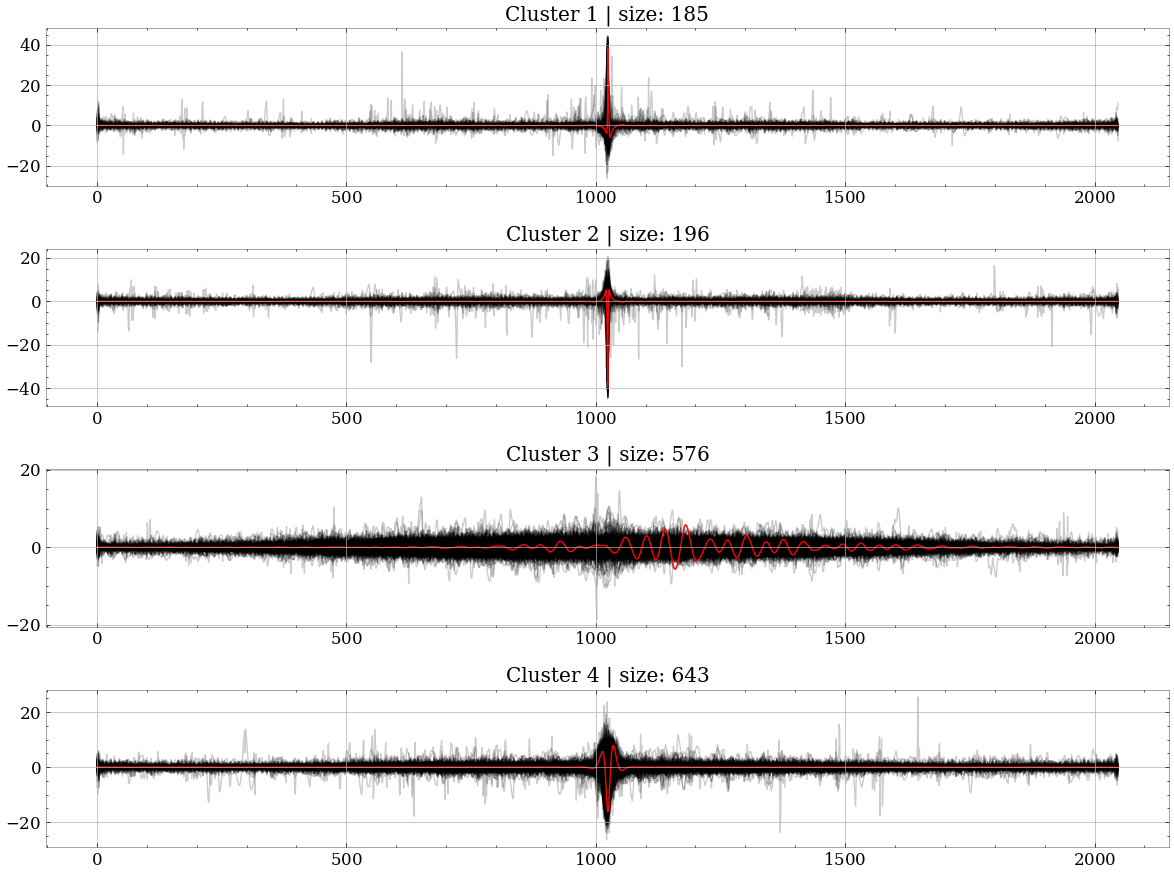

In [ ]:
plt.figure(figsize=(12,9))

for yi in range(len(ghat_labels_uq)):
    plt.subplot(len(ghat_labels_uq),1,yi+1)
    for xx in X_train_ts_scaled[y_pred_ks == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(ks.cluster_centers_[yi].ravel(), "r-")
    plt.title(f"Cluster {yi+1} | size: {np.sum(y_pred_ks==yi)}")
plt.tight_layout()
plt.show()

In [ ]:
# here we do NOT assign initial centroids from known labeled classes, but pick random init and try for 10 times
ks_random = KShape(n_clusters=len(ghat_labels_uq),random_state=42,n_init=10,init='random')
y_pred_ks_random = ks_random.fit_predict(X_train_ts_scaled)

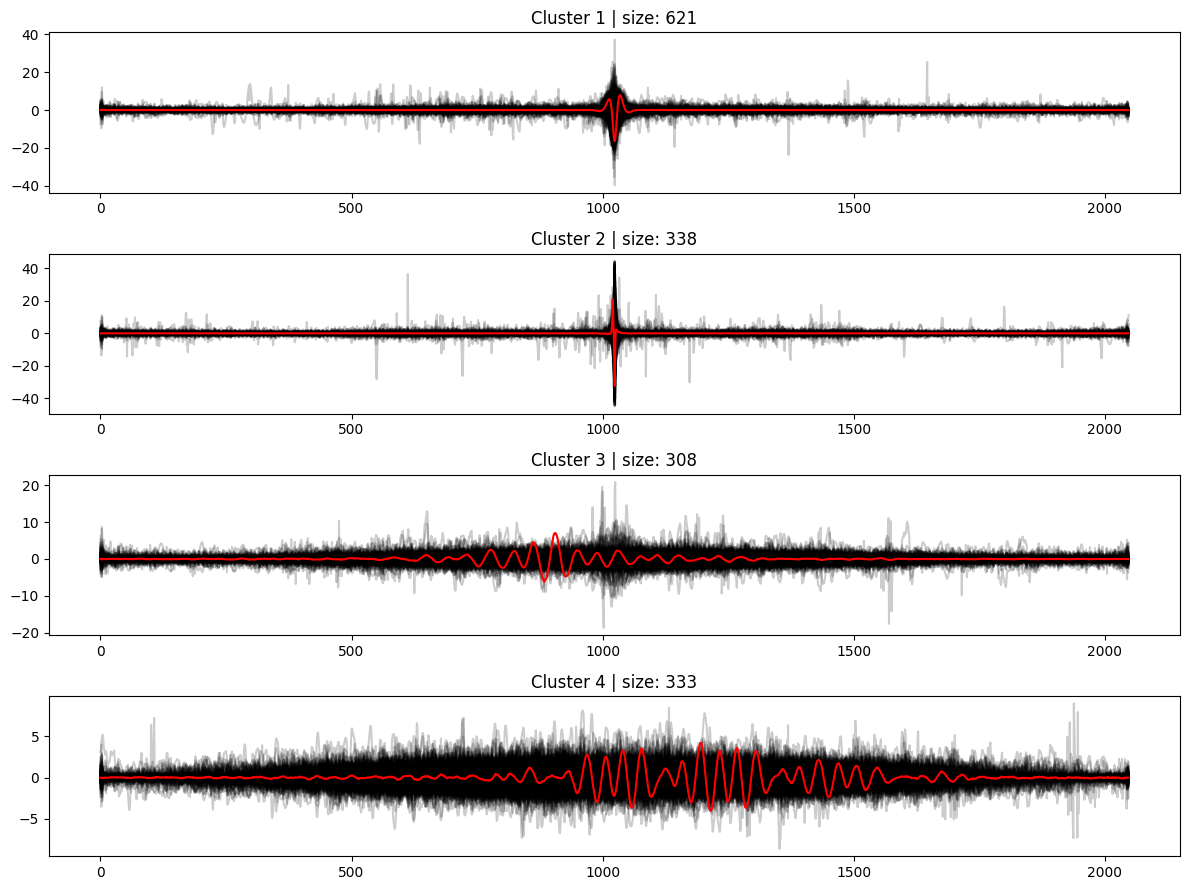

In [22]:
label_uq_ksrandom = np.unique(y_pred_ks_random)
plt.figure(figsize=(12,9))

for yi in range(len(label_uq_ksrandom)):
    plt.subplot(len(label_uq_ksrandom),1,yi+1)
    for xx in X_train_ts_scaled[y_pred_ks_random == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(ks_random.cluster_centers_[yi].ravel(), "r-")
    plt.title(f"Cluster {yi+1} | size: {np.sum(y_pred_ks_random==yi)}")
plt.tight_layout()
plt.show()

In [ ]:
# save the trained KShape models
import pathlib

model_dir = pathlib.Path('./kshape_models')
model_dir.mkdir(parents=True,exist_ok=True)
ks.to_pickle(model_dir/'kshape_model_initialized_with_gravity_spy_labels.pkl')
ks_random.to_pickle(model_dir/'kshape_model_random_initialization.pkl')

In [ ]:
# half-supervised kshape clustering, centroid initialization consist of known labels + randomly selected samples

from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import train_test_split
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
from tslearn.clustering import KShape
from tslearn.metrics import cdist_normalized_cc

np.random.seed(42)

df_train, df_test = train_test_split(ghat_df, train_size=0.8, random_state=42,stratify=ghat_df['label'],shuffle=True)

ghat_train = np.array(df_train.ghat.to_list())
label_train = np.array(df_train.label.to_list())
ghat_test = np.array(df_test.ghat.to_list())
label_test = np.array(df_test.label.to_list())


X_train_ts = to_time_series_dataset(ghat_train)
X_test_ts = to_time_series_dataset(ghat_test)

# resample timeseries to smaller size for faster computation
sz_resample = 2048
X_train_ts_resampled = TimeSeriesResampler(sz=sz_resample).fit_transform(X_train_ts)
X_test_ts_resampled = TimeSeriesResampler(sz=sz_resample).fit_transform(X_test_ts)
X_train_ts_scaled = TimeSeriesScalerMeanVariance().fit_transform(X_train_ts_resampled)
X_test_ts_scaled = TimeSeriesScalerMeanVariance().fit_transform(X_test_ts_resampled)

k_range = range(3,10) # number of clusters to try 3,4,5,6,7,8,9
inertia_half_supervised_list = []
ARI_half_supervised_list = []

known_centroids = []

ks_half_supervised_list = []
y_pred_ks_half_supervised_list = []
init_centroids_half_supervised_list = []

for i in range(len(ghat_labels_uq)):
    X_subset = X_train_ts_scaled[label_train == ghat_labels_uq[i]]
    ks_subset = KShape(n_clusters=1,random_state=42,init='random')
    ks_subset.fit(X_subset)
    known_centroids.append(ks_subset.cluster_centers_[0]) # get centroid for each known labeled class

# define a function to pick random samples as initial centroids for unknown clusters, we need to make sure their distances from
# known centroids are large enough than certain threshold (to avoid overlapping clusters)
def sbd_distance_matrix(X,Y):
    X_norms = np.linalg.norm(X,axis=(1,2))
    Y_norms = np.linalg.norm(Y,axis=(1,2))
    ncc_matrix = cdist_normalized_cc(X,Y,norms1=X_norms,norms2=Y_norms,self_similarity=False)
    return 1. - ncc_matrix



def get_safe_initial_centroids(X, known_centroids, n_random, threshold=0.5): # X: timeseries dataset (n_samples,sz,1), known_centroids: list of known centroids, n_random: number of random centroids to pick, threshold: min squared distance from known centroids (0,2)
    centroids = known_centroids.copy()
    candidate_indices = np.random.permutation(len(X))
    for i in candidate_indices:
        candidate_sample = X[i].reshape(1,2048,1)
        dist_array = sbd_distance_matrix(candidate_sample, np.array(centroids)) # compute distances to known centroids & previously selected random centroids
        if np.min(dist_array**2) >= threshold: # inertia from kshape algorithm uses squared distances, we also square the distances here
            centroids.append(X[i])
            if len(centroids) >= len(known_centroids) + n_random:
                return centroids # return list of centroids
    raise ValueError("Could not find enough safe random samples after going through all candidates") # if not found within max tries, raise error and abort



for k in k_range:
    if k < len(ghat_labels_uq):
        ks_half_supervised = KShape(n_clusters=k,random_state=42,init='random',n_init=10) # if k less than known clusters, random initialize
        init_centroids = 'random_initialization'
    else:
        n_random = k - len(ghat_labels_uq) # number of unknown clusters to add
        if n_random > 0:
            init_centroids = get_safe_initial_centroids(X_train_ts_scaled,known_centroids,n_random,threshold=0.5)
        else:
            init_centroids = known_centroids # k=4
        ks_half_supervised = KShape(n_clusters=k,random_state=42,init=np.array(init_centroids))
    y_pred_ks_half_supervised = ks_half_supervised.fit_predict(X_train_ts_scaled)
    ks_half_supervised_list.append(ks_half_supervised)
    y_pred_ks_half_supervised_list.append(y_pred_ks_half_supervised)
    init_centroids_half_supervised_list.append(init_centroids)
    inertia_half_supervised_list.append(ks_half_supervised.inertia_)
    ARI_half_supervised_list.append(adjusted_rand_score(label_train,y_pred_ks_half_supervised)) # compare predicted labels with known labels



In [379]:
for ks in ks_half_supervised_list:
    ks.to_pickle(model_dir/f'k{ks.n_clusters}_kshape_half_supervised_model.pkl')

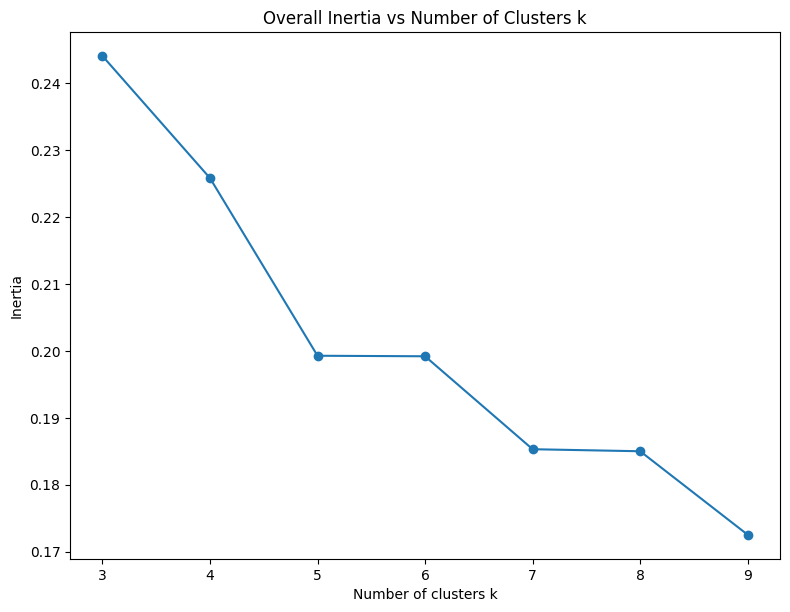

In [390]:
fig, ax1 = plt.figure(figsize=(8,6)), plt.gca()

ax1.set_xlabel('Number of clusters k')
# ax1.set_ylabel('Inertia', color='tab:blue')
ax1.set_ylabel('Inertia')
ax1.plot(k_range, inertia_half_supervised_list, marker='o', color='tab:blue', label='Inertia')
# ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.tick_params(axis='y')

# ax2 = ax1.twinx()
# ax2.set_ylabel('Adjusted Rand Index (ARI)', color='tab:red')
# ax2.plot(k_range, ARI_half_supervised_list, marker='s', color='tab:red', label='ARI')
# ax2.tick_params(axis='y', labelcolor='tab:red')

# fig.tight_layout()
# plt.title('Inertia and Adjusted Rand Index (ARI) vs Number of Clusters k')
# plt.show() 

fig.tight_layout()
plt.title('Overall Inertia vs Number of Clusters k')
plt.show() 

In [170]:
# function to calculate inertia for data within certain cluster; average squared distance from data points to CERTAIN centroid
# remember inertia is sum of squared distances from data points to centroid, but we just calc for a subset instead of whole dataset like method from Kshape
def calc_single_cluster_inertia(ks, X, y, certain_label):
    X_subset = X[y == certain_label]
    centroid = ks.cluster_centers_[certain_label]
    sub_dist_array = sbd_distance_matrix(X_subset, centroid.reshape(1,2048,1))
    inertia = np.sum(sub_dist_array**2)/X_subset.shape[0]
    return inertia

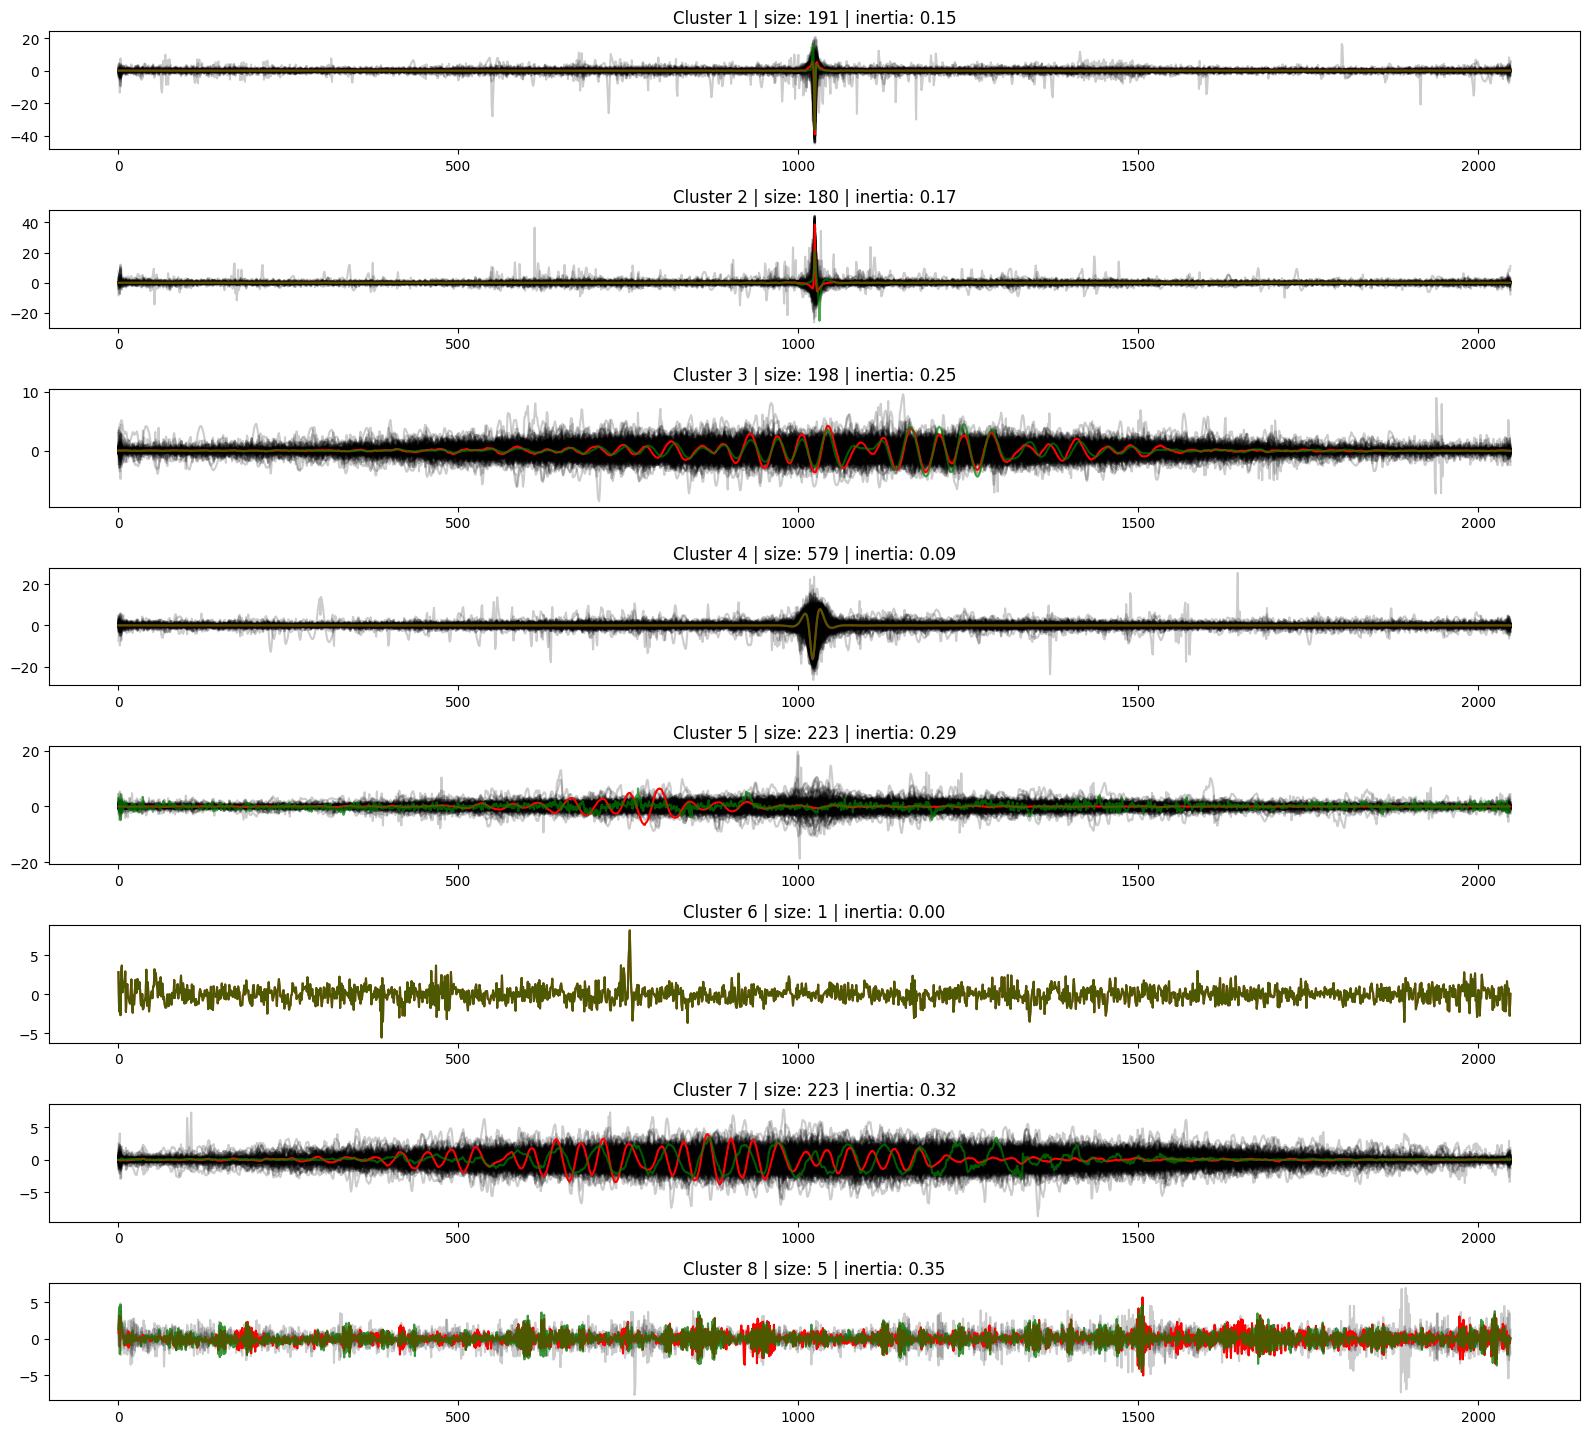

Average inertia: 0.20178
Total inertia from KShape model: 0.18499


In [387]:
# draw cluster centeroids for kbest from elbow method and ARI

kbest = 8
ks_best = ks_half_supervised_list[kbest - min(k_range)]
y_pred_ks_best = y_pred_ks_half_supervised_list[kbest - min(k_range)]
label_ks_best = np.unique(y_pred_ks_best)

inertia_add = 0
plt.figure(figsize=(16,16))
for j in range(len(label_ks_best)):
    plt.subplot(len(label_ks_best)+1,1,j+1)
    for xx in X_train_ts_scaled[y_pred_ks_best == j]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    sub_inertia = calc_single_cluster_inertia(ks_best, X_train_ts_scaled, y_pred_ks_best, j)
    plt.plot(ks_best.cluster_centers_[j].ravel(), "r-")
    plt.plot(init_centroids_half_supervised_list[kbest - min(k_range) ][j].ravel(), "g-", alpha=0.7)
    plt.title(f"Cluster {j+1} | size: {np.sum(y_pred_ks_best==j)} | inertia: {sub_inertia:.2f}")
    inertia_add += sub_inertia
plt.tight_layout()
plt.show()
average_inertia = inertia_add / len(label_ks_best)
print(f"Average inertia: {average_inertia:.5f}")
total_inertia = ks_best.inertia_
print(f"Total inertia from KShape model: {total_inertia:.5f}")

In [197]:
print(type(ks_best.cluster_centers_))
print(ks_best.cluster_centers_.shape)

<class 'numpy.ndarray'>
(5, 2048, 1)


In [135]:
distmat = ks_best._cross_dists(X_train_ts_scaled)

In [149]:
print(distmat[:10])

[[0.85009455 0.86234176 0.54935681 0.76951198 0.86028767]
 [0.5542946  0.78742689 0.72375926 0.11349569 0.76972204]
 [0.91406734 0.82384009 0.77851371 0.86137204 0.78655866]
 [0.64471746 0.74893468 0.67527216 0.04620269 0.69335083]
 [0.17147141 0.74173383 0.94497848 0.84206942 0.96049244]
 [0.61119224 0.72114277 0.69999876 0.02024517 0.73099976]
 [0.71942125 0.579015   0.50335679 0.39719622 0.62770633]
 [0.8875818  0.81779271 0.65086283 0.71616517 0.72743584]
 [0.35724423 0.36318235 0.9131193  0.69470175 0.92712818]
 [0.85746322 0.84926599 0.64504556 0.57356242 0.52832347]]


In [166]:
np.argwhere(y_pred_ks_best == 2)[:10]

array([[ 0],
       [ 2],
       [ 7],
       [11],
       [15],
       [18],
       [19],
       [23],
       [25],
       [30]])

In [167]:
subdistmat = sbd_distance_matrix(X_train_ts_scaled[y_pred_ks_best == 2],ks_best.cluster_centers_)
print(subdistmat[:10])
print(np.argmin(subdistmat,axis=1)[:10])
print(np.argmin(distmat,axis=1)[:10])
print(sbd_distance_matrix(ks_best.cluster_centers_[0].reshape(1,2048,1),ks_best.cluster_centers_[0].reshape(1,2048,1)))

[[0.85009455 0.86234176 0.54935681 0.76951198 0.86028767]
 [0.91406734 0.82384009 0.77851371 0.86137204 0.78655866]
 [0.8875818  0.81779271 0.65086283 0.71616517 0.72743584]
 [0.87054406 0.86087895 0.73263085 0.79249864 0.77783919]
 [0.94685376 0.93330016 0.52111353 0.8315595  0.70089671]
 [0.94814913 0.9259291  0.65015139 0.86615478 0.79531821]
 [0.85525146 0.87155231 0.41314709 0.53017477 0.59851244]
 [0.89119263 0.90483852 0.54032403 0.78818909 0.83130699]
 [0.8815042  0.8371657  0.70379765 0.79901695 0.71060739]
 [0.9304197  0.92374201 0.4873658  0.83270797 0.83500882]]
[2 2 2 2 2 2 2 2 2 2]
[2 3 2 3 0 3 3 2 0 4]
[[0.]]


In [229]:
# drawing function for visualizing cluster centroids and collection of time series in each cluster; 
# also display in-cluster inertia for each cluster
def plot_clusters_with_in_cluster_inertia(ks_model, X_ts, y_pred):
    n_clusters = ks_model.n_clusters
    fig, axes = plt.subplots(n_clusters, 1, figsize=(12, 3 * n_clusters))
    if n_clusters == 1:
        axes = [axes]
    for cluster_idx in range(n_clusters):
        ax = axes[cluster_idx]
        cluster_members = X_ts[y_pred == cluster_idx]
        for ts in cluster_members:
            ax.plot(ts.ravel(), color='gray', alpha=0.2)
        centroid = ks_model.cluster_centers_[cluster_idx]
        inertia = calc_single_cluster_inertia(ks_model, X_ts, y_pred, cluster_idx)
        ax.plot(centroid.ravel(), color='red', linewidth=2)
        ax.set_title(f'Cluster {cluster_idx + 1} (k={ks_model.n_clusters}) - Size: {cluster_members.shape[0]} - Inertia: {inertia:.3f}')
    plt.suptitle(f'KShape Clustering Results (k={ks_model.n_clusters}) with in-cluster inertia',fontsize=16,fontweight='bold')
    plt.tight_layout()
    plt.show()

In [ ]:
plot_clusters_with_in_cluster_inertia(ks_best, X_train_ts_scaled, y_pred_ks_best)

In [8]:
from tslearn.clustering import KShape
import pathlib

model_dir = pathlib.Path('./kshape_models')

k_range = range(3,10)
ks_load_list = []
y_pred_load_list = []
for j in k_range:
    ks_load_list.append(KShape.from_pickle(model_dir/f'k{j}_kshape_half_supervised_model.pkl'))
    y_pred_load_list.append(ks_load_list[-1].predict(X_train_ts_scaled))

In [ ]:
kbest = 5
ks_best = ks_load_list[kbest - min(k_range)]
y_pred_ks_best = y_pred_load_list[kbest - min(k_range)]

plot_clusters_with_in_cluster_inertia(ks_best, X_train_ts_scaled, y_pred_ks_best)

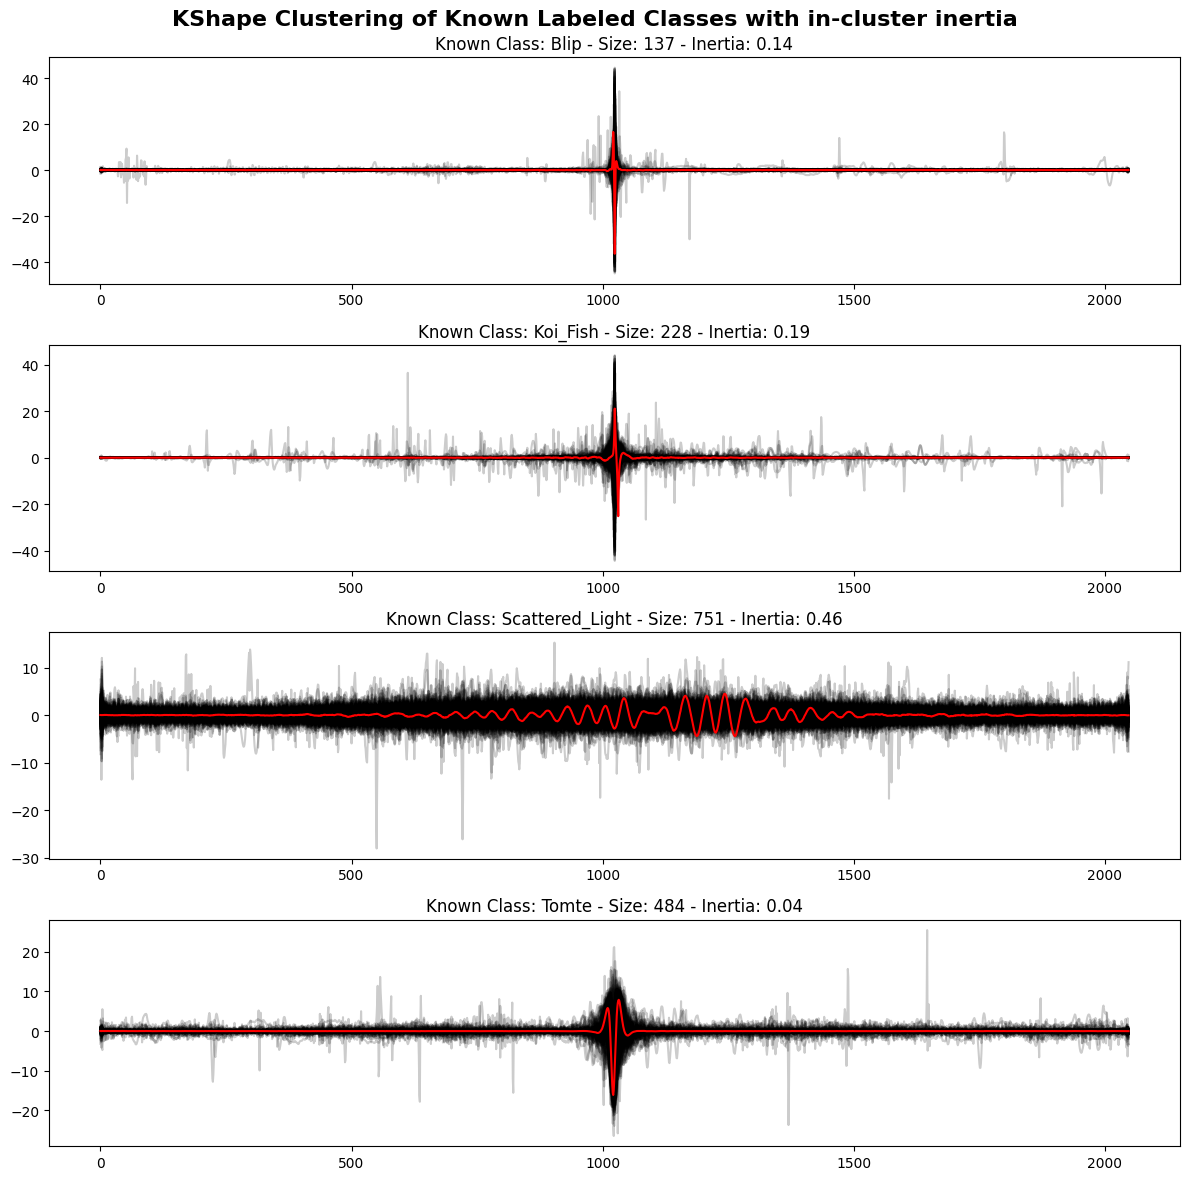

In [386]:
known_centroids = []
inertia_subset_list = []
ks_list = []
fig, axes = plt.subplots(len(ghat_labels_uq), 1, figsize=(12, 3 * len(ghat_labels_uq)))
for i in range(len(ghat_labels_uq)):
    X_subset = X_train_ts_scaled[label_train == ghat_labels_uq[i]]
    ks_subset = KShape(n_clusters=1,random_state=42,init='random')
    ks_subset.fit(X_subset)
    ks_list.append(ks_subset)
    known_centroids.append(ks_subset.cluster_centers_[0]) # get centroid for each known labeled class
    inertia_subset_list.append(ks_subset.inertia_)
    for j in range(X_subset.shape[0]):
        axes[i].plot(X_subset[j].ravel(), "k-", alpha=.2)
    axes[i].plot(known_centroids[i].ravel(), "r-")
    axes[i].set_title(f'Known Class: {ghat_labels_uq[i]} - Size: {X_subset.shape[0]} - Inertia: {inertia_subset_list[-1]:.2f}')
plt.suptitle('KShape Clustering of Known Labeled Classes with in-cluster inertia',fontsize=16,fontweight='bold')
plt.tight_layout()
plt.show()

In [189]:
distmat_new1 = sbd_distance_matrix(ks_list[0].cluster_centers_[0].reshape(1,2048,1),ks_list[1].cluster_centers_[0].reshape(1,2048,1)) # distance between class 0 and class 1 centroids
print(distmat_new1)

[[0.45700083]]


In [ ]:
# define a function to pick random samples as initial centroids for unknown clusters, we need to make sure their distances from
# known centroids are large enough than certain threshold (to avoid overlapping clusters)
def sbd_distance_matrix(X,Y):
    X_norms = np.linalg.norm(X,axis=(1,2))
    Y_norms = np.linalg.norm(Y,axis=(1,2))
    ncc_matrix = cdist_normalized_cc(X,Y,norms1=X_norms,norms2=Y_norms,self_similarity=False)
    return 1. - ncc_matrix

# function to calculate inertia for data within certain cluster; 
# remember inertia is sum of squared distances from data points to centroid, but we just calc for a subset instead of whole dataset like method from Kshape
def calc_single_cluster_inertia(ks, X, y, certain_label):
    X_subset = X[y == certain_label]
    centroid = ks.cluster_centers_[certain_label]
    sub_dist_array = sbd_distance_matrix(X_subset, centroid.reshape(1,2048,1))
    inertia = np.sum(sub_dist_array**2)/X_subset.shape[0]
    return inertia

# drawing function for visualizing cluster centroids and collection of time series in each cluster
def plot_clusters_with_in_cluster_inertia(ks_model, X_ts, y_pred):
    n_clusters = ks_model.n_clusters
    fig, axes = plt.subplots(n_clusters, 1, figsize=(12, 3 * n_clusters))
    if n_clusters == 1:
        axes = [axes]
    for cluster_idx in range(n_clusters):
        ax = axes[cluster_idx]
        cluster_members = X_ts[y_pred == cluster_idx]
        for ts in cluster_members:
            ax.plot(ts.ravel(), color='gray', alpha=0.2)
        centroid = ks_model.cluster_centers_[cluster_idx]
        inertia = calc_single_cluster_inertia(ks_model, X_ts, y_pred, cluster_idx)
        ax.plot(centroid.ravel(), color='red', linewidth=2)
        ax.set_title(f'Cluster {cluster_idx + 1} (k={ks_model.n_clusters}) - Size: {cluster_members.shape[0]} - Inertia: {inertia:.3f}')
    plt.suptitle(f'KShape Clustering Results (k={ks_model.n_clusters}) with in-cluster inertia',fontsize=16,fontweight='bold')
    plt.tight_layout()
    plt.show()

# Exclude known classes to find new classes of glitches: 
# 1. for classes with high in-cluster inertia, increase number of centroids to split them into smaller clusters; for claases with low in-cluster inertia, keep number of centroids as 1
# 2. kshape cluster for each known classes with customized number of centroids in step 1; get centroids
# 3. for each sample, calculate its distances to all centroids from step 2
# 4. samples with distances larger than certain threshold to all centroids are considered as new classes of glitches, gather them
# 5. kshape cluster the gathered new classes of glitches to find new glitch classes
import matplotlib.pyplot as plt


n_centroids_per_class = { # customize number of centroids for each known class, Blip and Koi_Fish with 0.1-0.2 inertia can be split into 2 clusters each; Scattered_Light with >0.4 inertia can be split into 4 clusters; Tomte with 0.04 inertia keep as 1 cluster
    'Blip': 2, 
    'Koi_Fish': 2, 
    'Scattered_Light': 4, 
    'Tomte': 1,
}
divided_centroids_ls = []
ks_subcls_dict = {}
label_centroid_ls = []

for label in ghat_labels_uq:
    X_subcls = X_train_ts_scaled[label_train == label]
    k = n_centroids_per_class.get(label, 1)
    ks_subcls = KShape(n_clusters=k, random_state=42, init='random', n_init=10)
    ks_subcls.fit(X_subcls)
    ks_subcls_dict[label] = ks_subcls # store the kshape model for each known class
    for j in range(k):
        label_centroid_ls.append(f'{label}')
    divided_centroids_ls.append(ks_subcls.cluster_centers_)

all_centroids = np.concatenate(divided_centroids_ls, axis=0) # shape (n_total_centroids, sz, 1)

distance_matrix_all_centroids = sbd_distance_matrix(X_train_ts_scaled, all_centroids) # shape (n_samples, n_total_centroids)

unknown_threshold = 0.6
unknown_mask = distance_matrix_all_centroids.min(axis=1) > unknown_threshold 
X_unknown = X_train_ts_scaled[unknown_mask]
y_unknown = label_train[unknown_mask]
print(f'Number of unknown samples identified: {X_unknown.shape[0]}')



Number of unknown samples identified: 269


In [357]:
all_centroids.shape

(9, 2048, 1)

----------Plotting clusters for known class: Blip----------


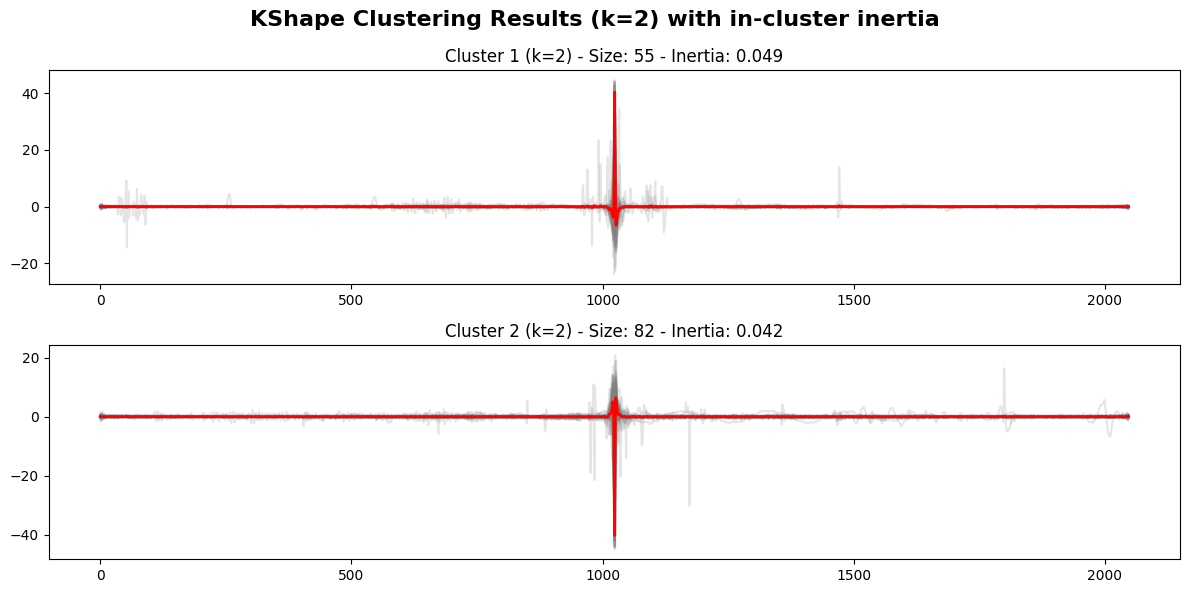

finished

----------Plotting clusters for known class: Koi_Fish----------


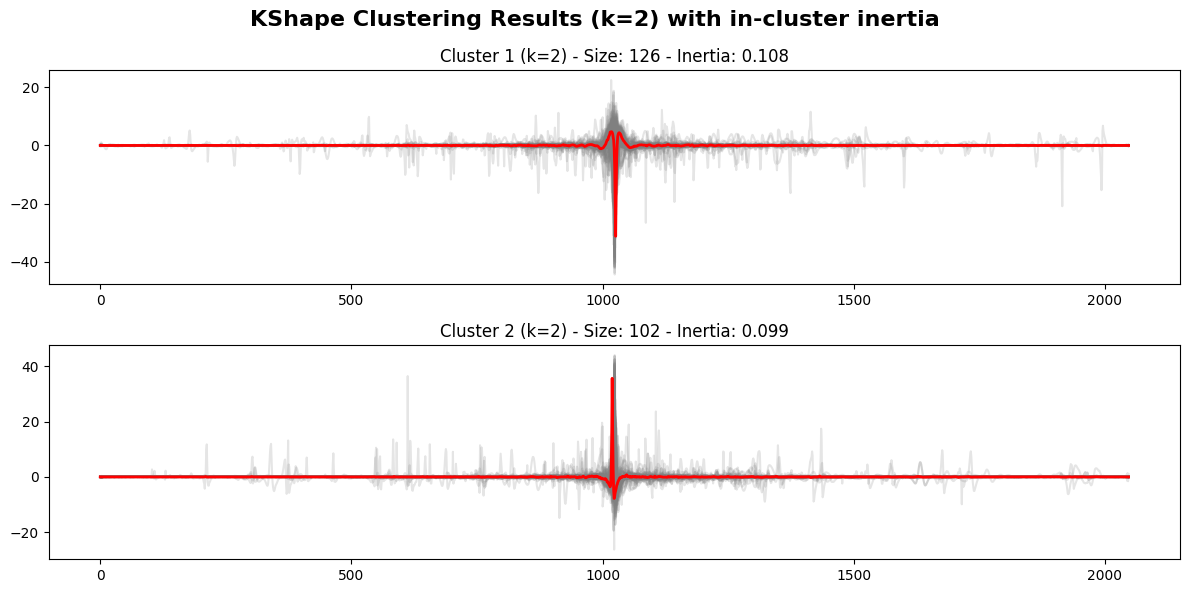

finished

----------Plotting clusters for known class: Scattered_Light----------


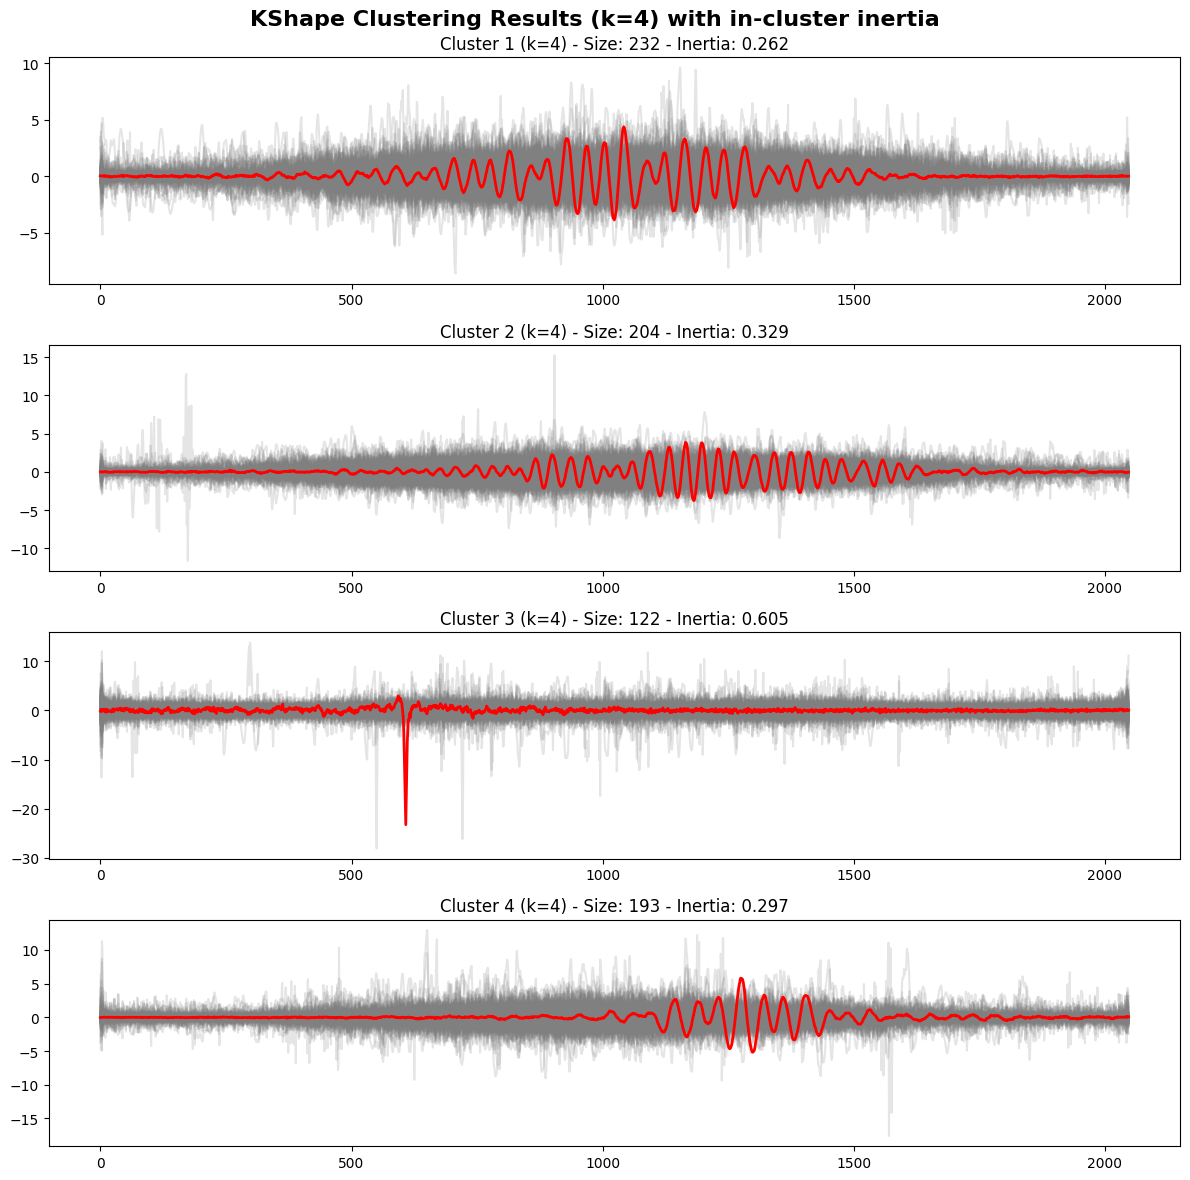

finished

----------Plotting clusters for known class: Tomte----------


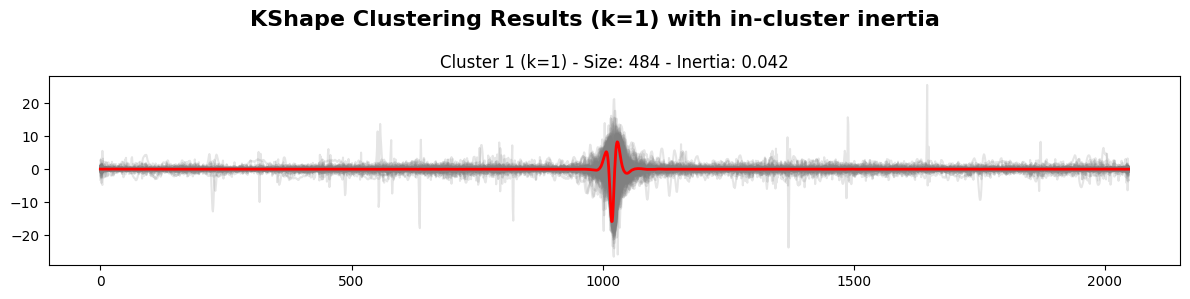

finished



In [235]:
# for our classes with renewed centroids, plot their members and centroids and inertia in each cluster
for label in ghat_labels_uq:
    ks_model_sub = ks_subcls_dict[label]
    X_subcls = X_train_ts_scaled[label_train == label]
    y_pred_subcls = ks_model_sub.predict(X_subcls)
    print(f'----------Plotting clusters for known class: {label}----------')
    plot_clusters_with_in_cluster_inertia(ks_model_sub, X_subcls, y_pred_subcls)
    print('finished\n')

Clustering unknown samples into 1 clusters:


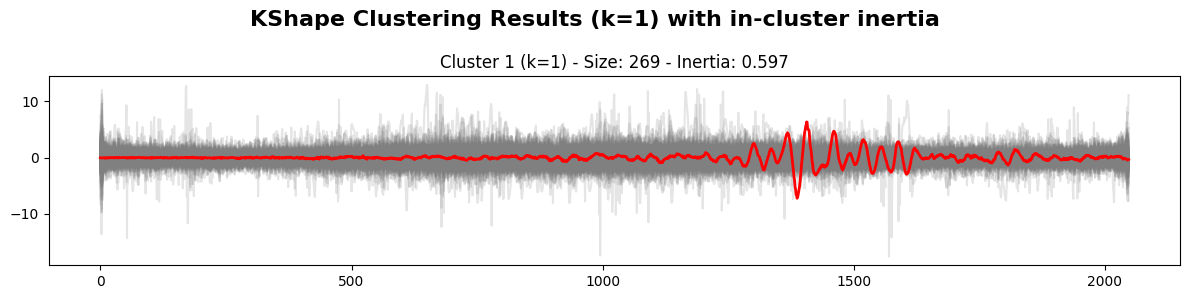

Clustering unknown samples into 2 clusters:


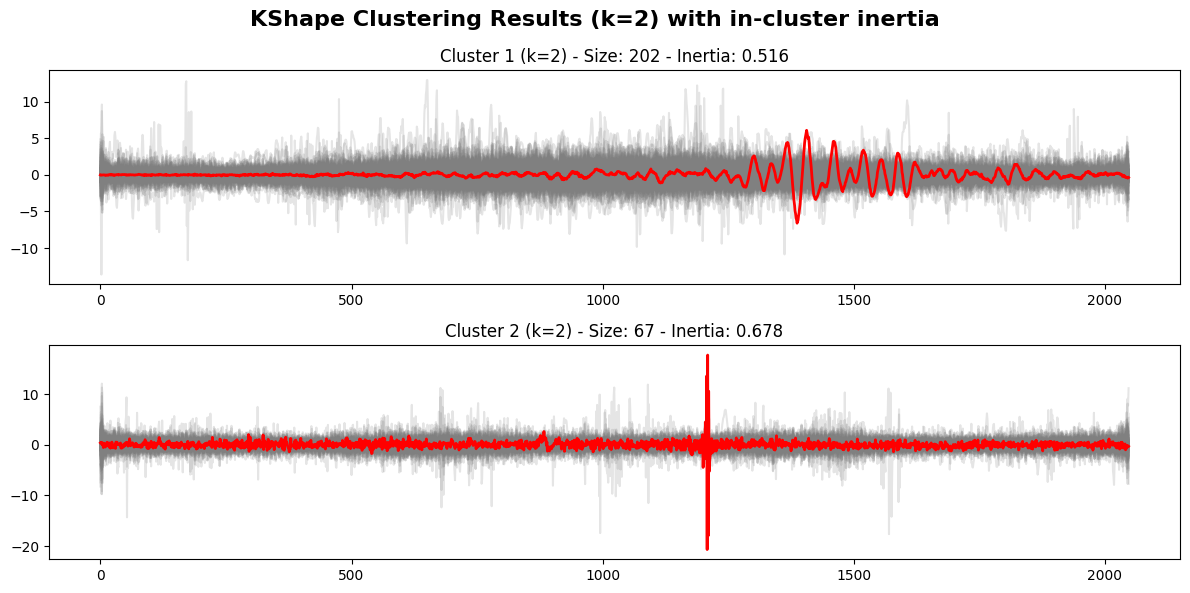

Clustering unknown samples into 3 clusters:


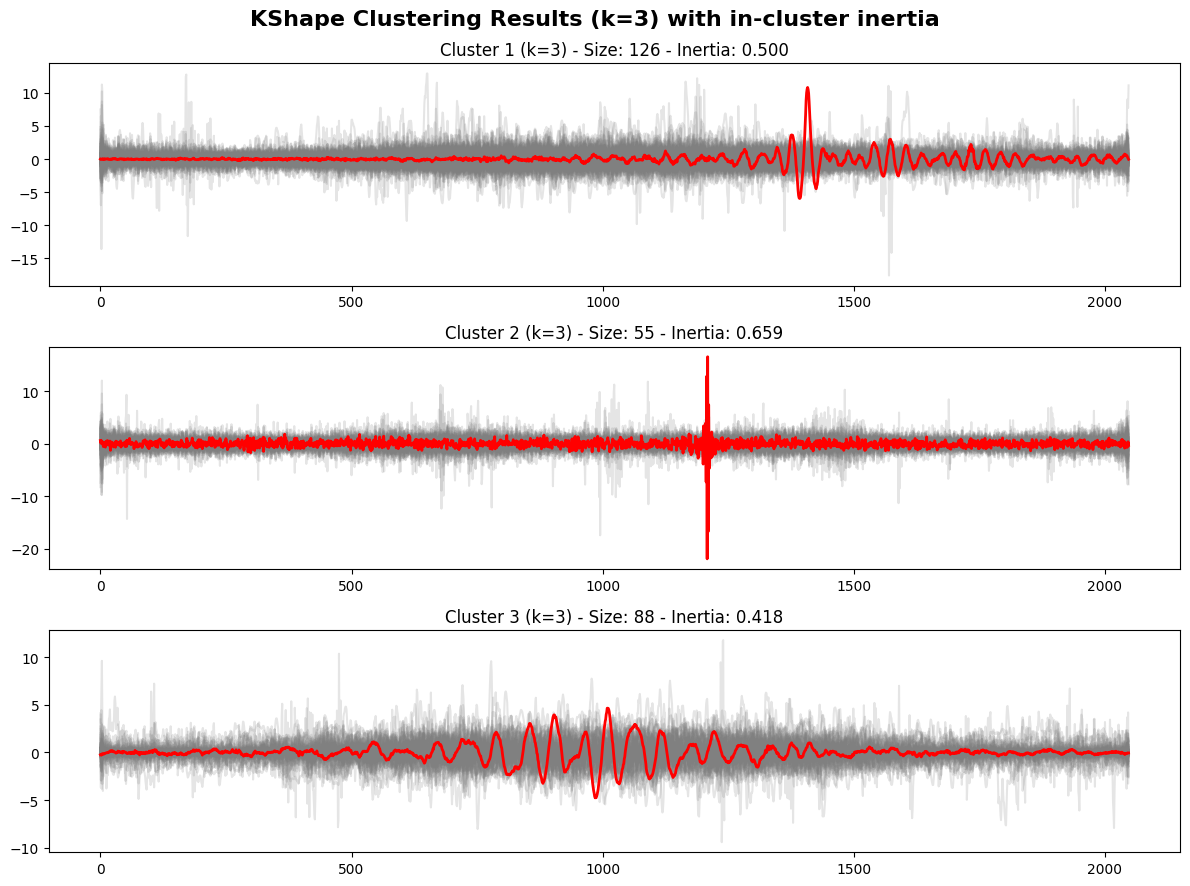

Clustering unknown samples into 4 clusters:


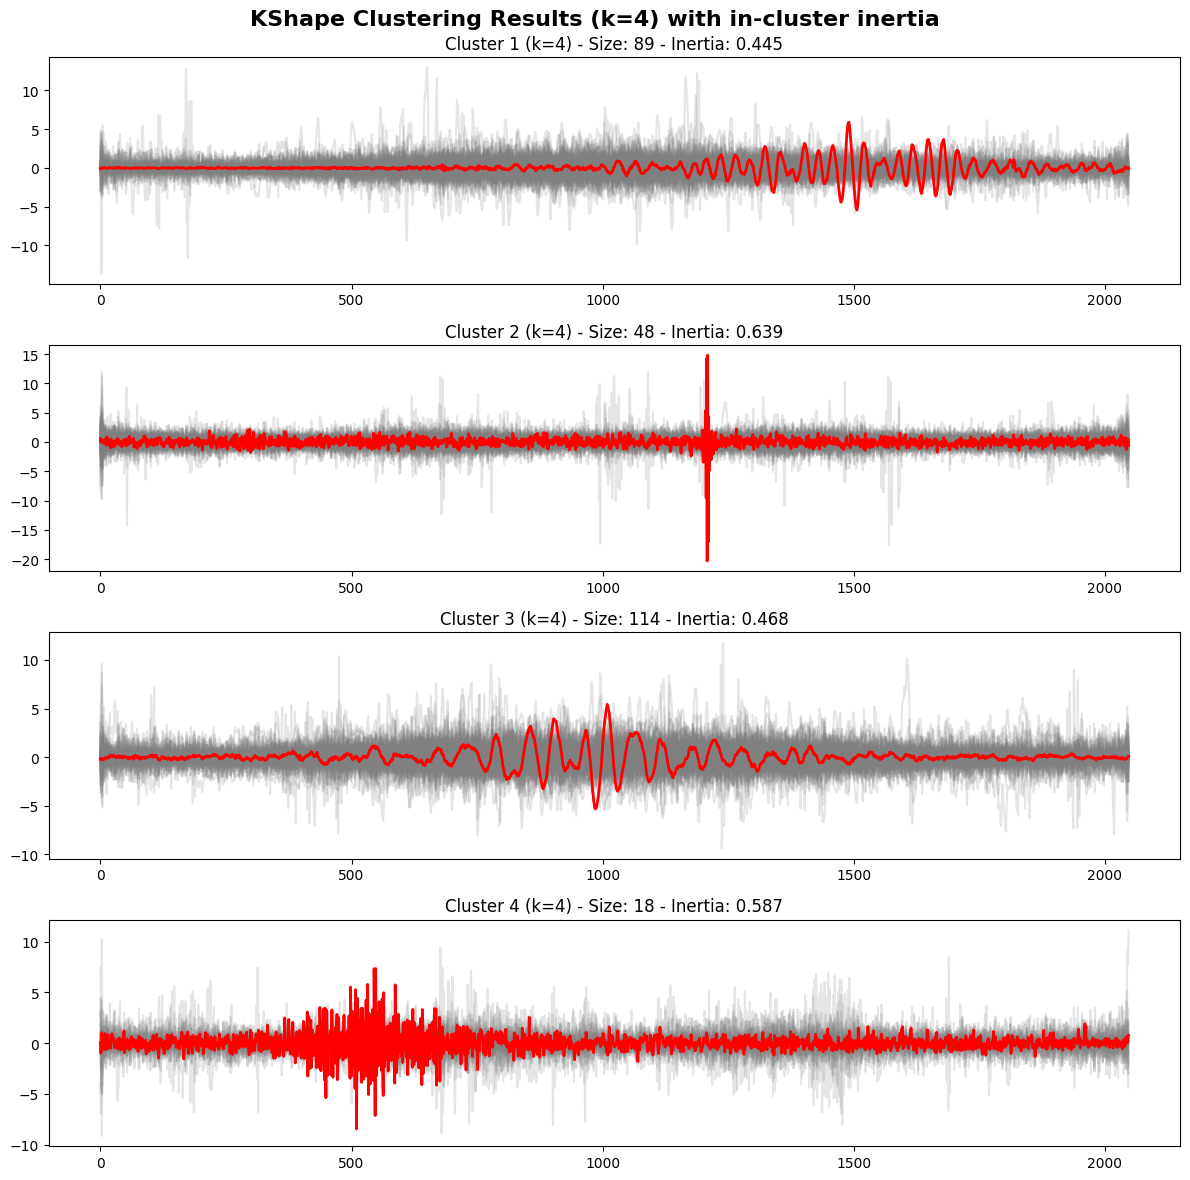

Clustering unknown samples into 5 clusters:


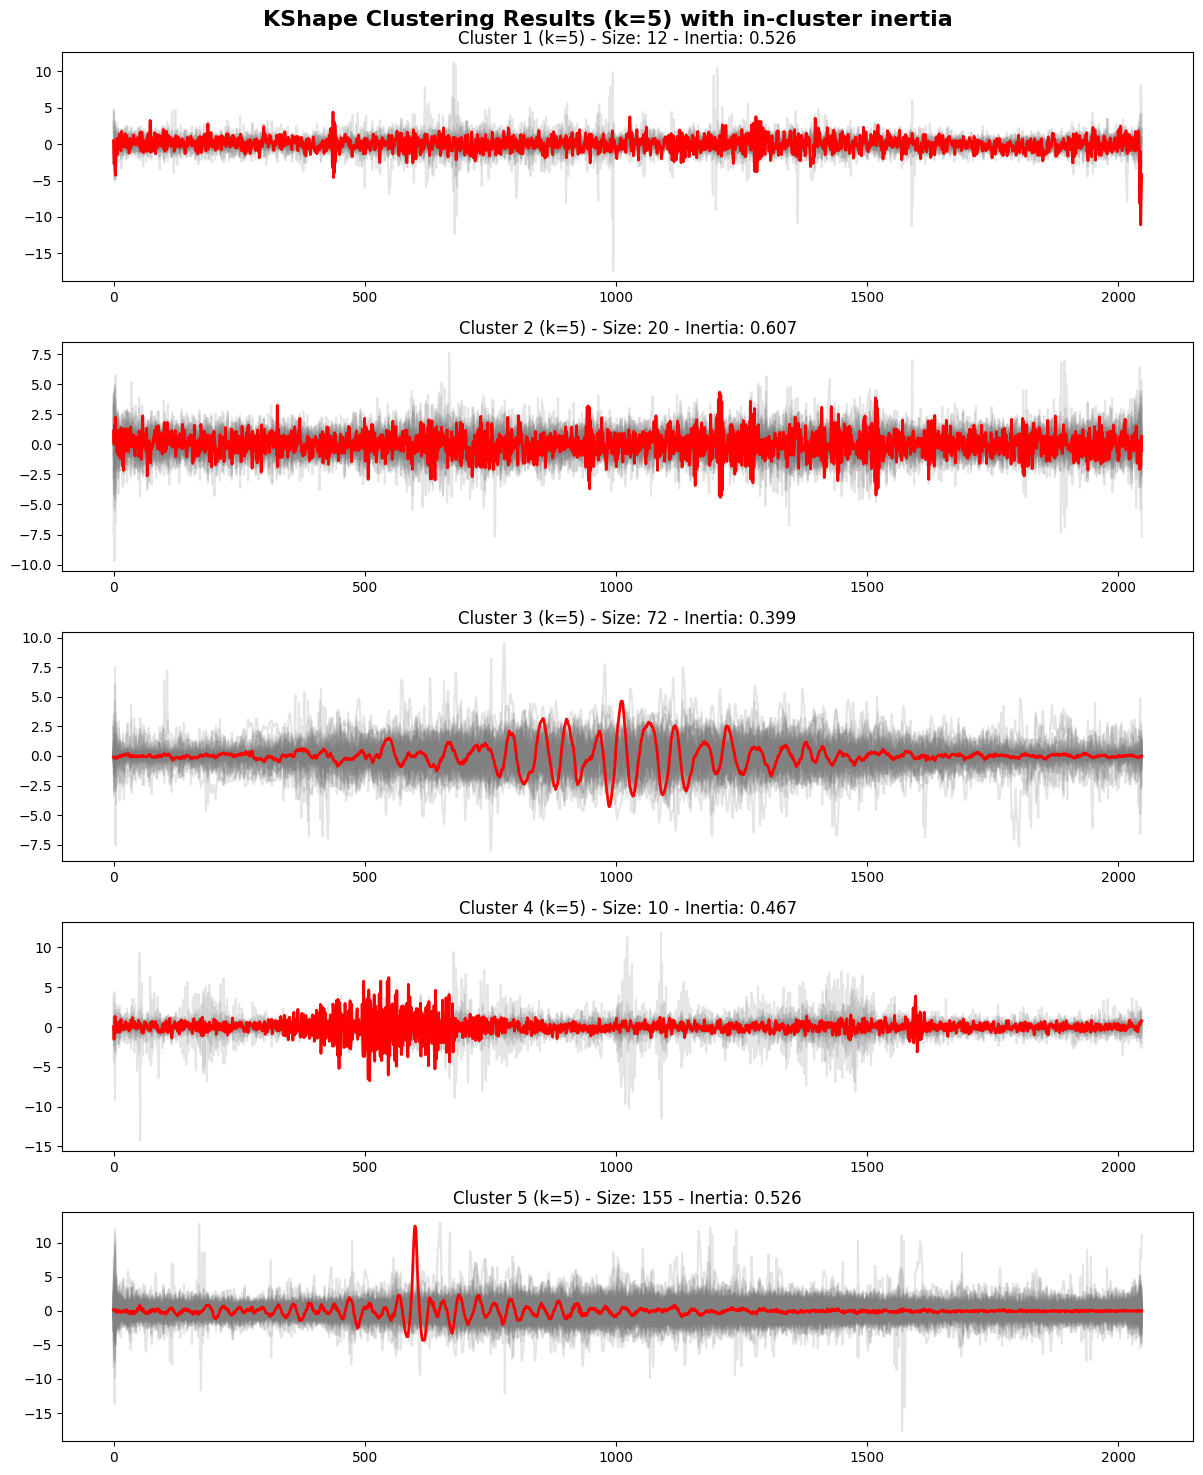

In [236]:
# Cluster unknown samples into different number of clusters, plot inertia vs number of clusters, and plot histogram of clusters' size for each k

overall_inertia_ls = []
clusters_size_ls = [] # each k has n_cluster, each cluster has size
ks_unknown_ls = []
y_pred_unknown_ls = []
k_unknown_range = range(1,6)
for k in k_unknown_range: # try clustering unknown samples into 1 to 5 clusters
    ks_unknown = KShape(n_clusters=k, random_state=42, init='random', n_init=10)
    y_pred_unknown = ks_unknown.fit_predict(X_unknown)
    print(f'Clustered unknown samples into {k} clusters')
    #plot_clusters_with_in_cluster_inertia(ks_unknown, X_unknown, y_pred_unknown)
    overall_inertia_ls.append(ks_unknown.inertia_)
    ks_unknown_ls.append(ks_unknown)
    y_pred_unknown_ls.append(y_pred_unknown)
    all_clusters_size_ls = []
    for j in range(ks_unknown.n_clusters):
        cluster_size = np.sum(y_pred_unknown == j)
        all_clusters_size_ls.append(cluster_size)
    clusters_size_ls.append(all_clusters_size_ls) # list of lists




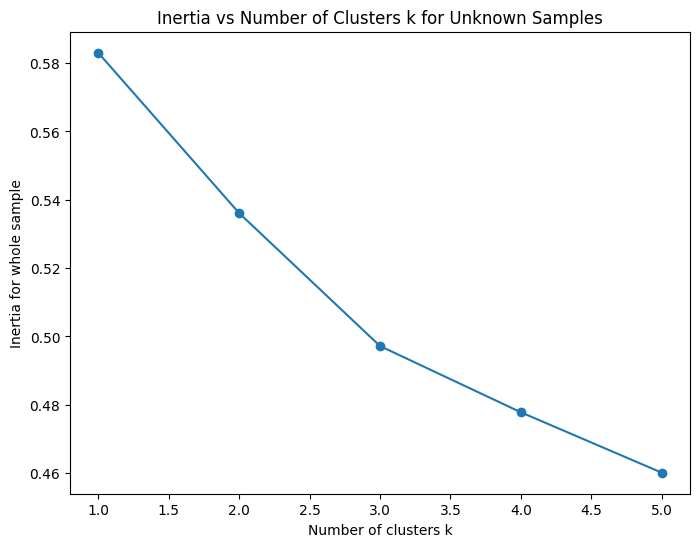

----------Plotting clusters for unknown samples with k=1----------


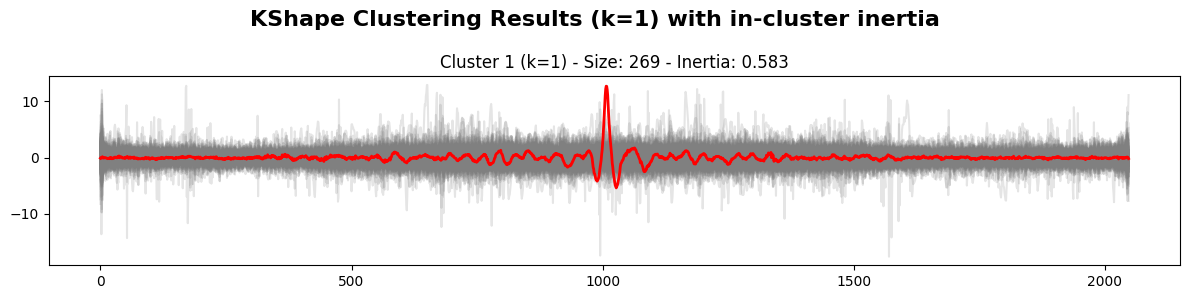

finished

----------Plotting clusters for unknown samples with k=2----------


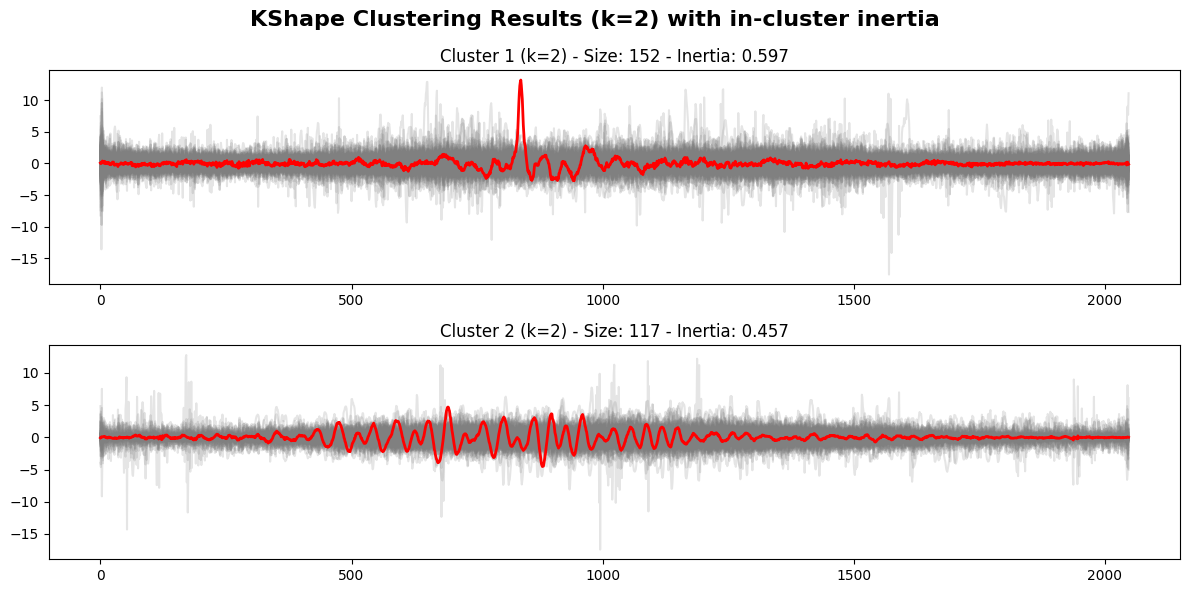

finished

----------Plotting clusters for unknown samples with k=3----------


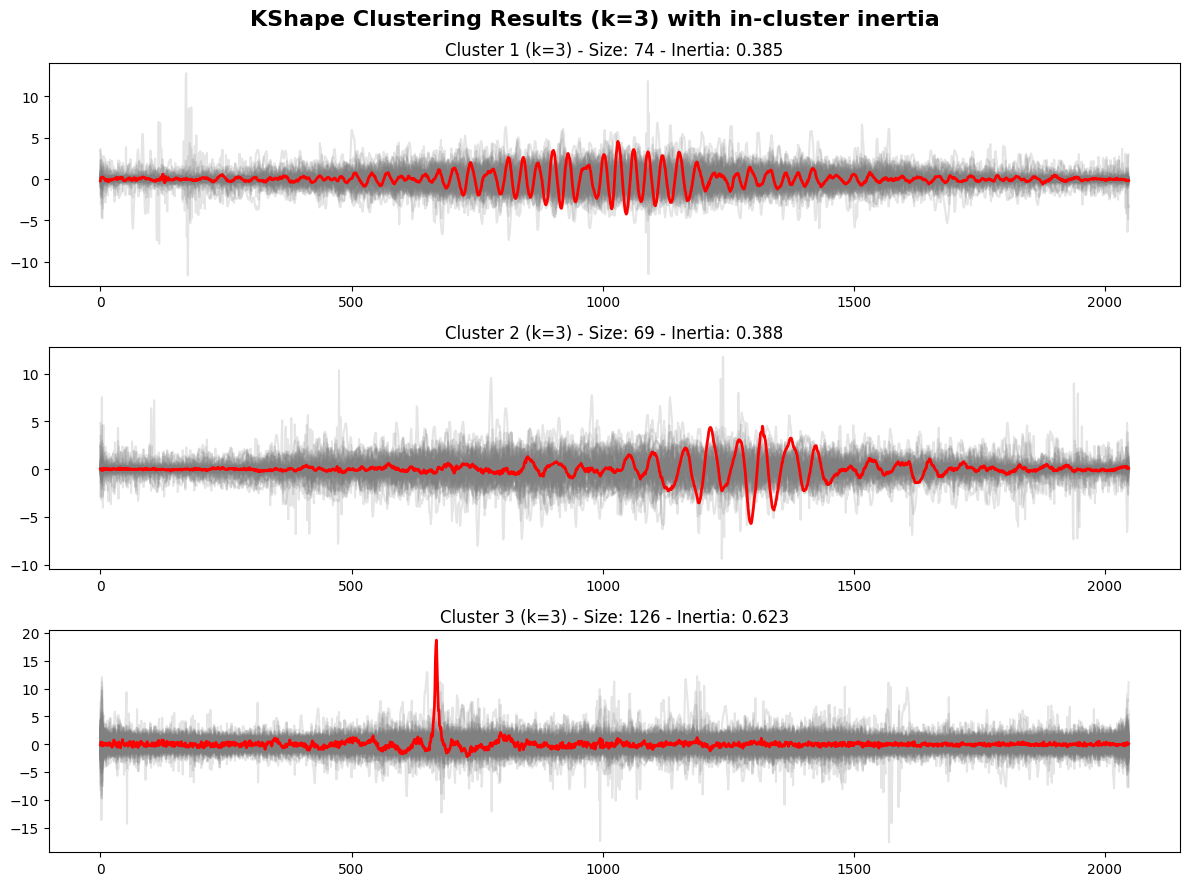

finished

----------Plotting clusters for unknown samples with k=4----------


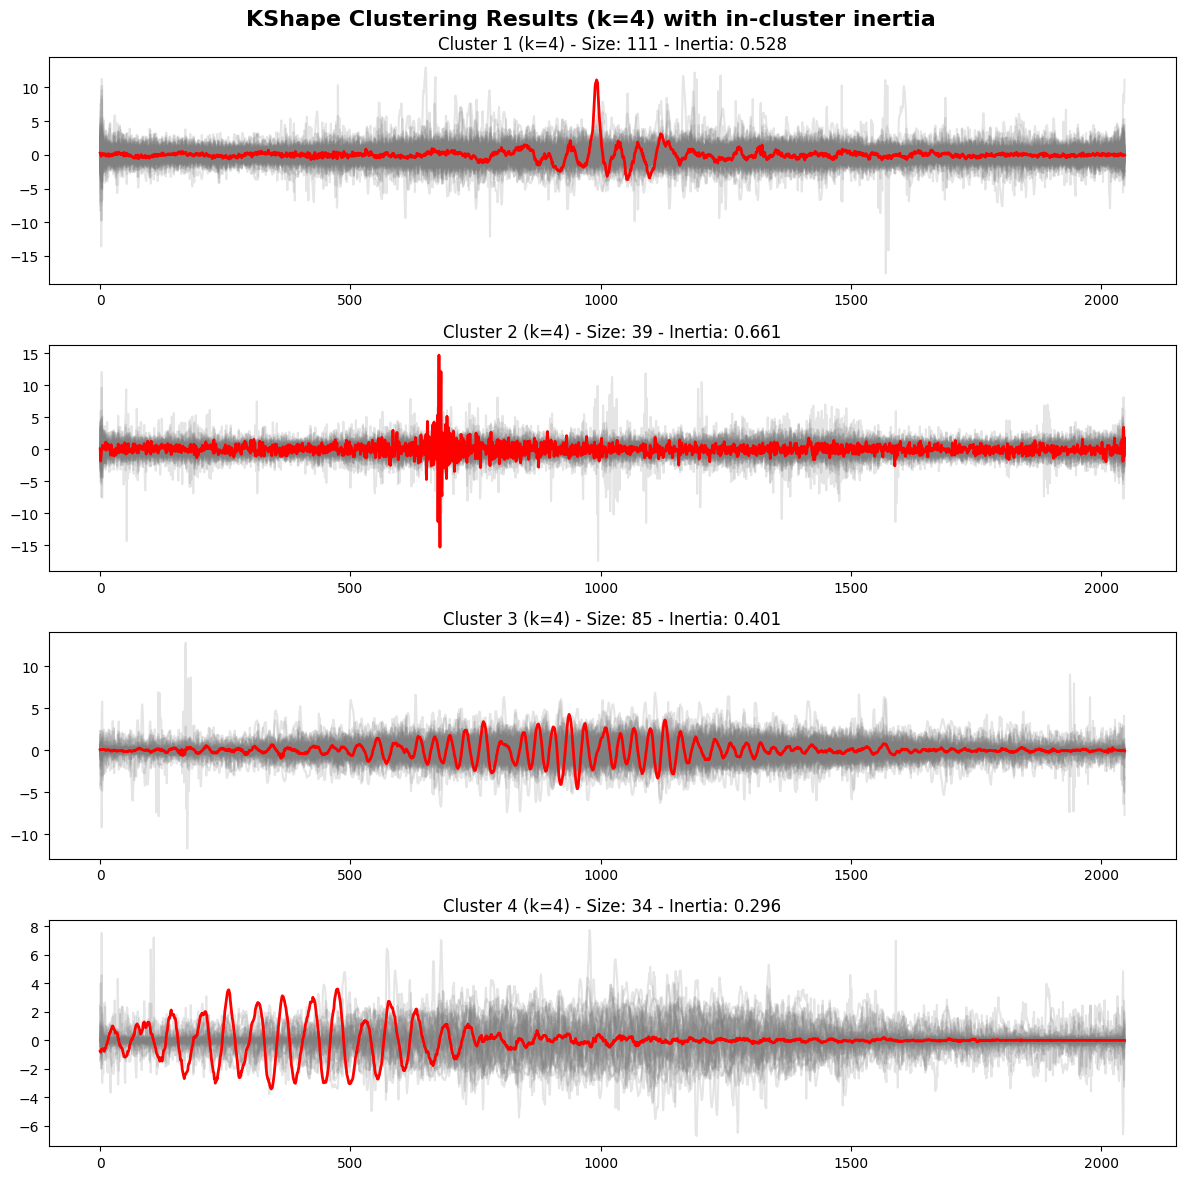

finished

----------Plotting clusters for unknown samples with k=5----------


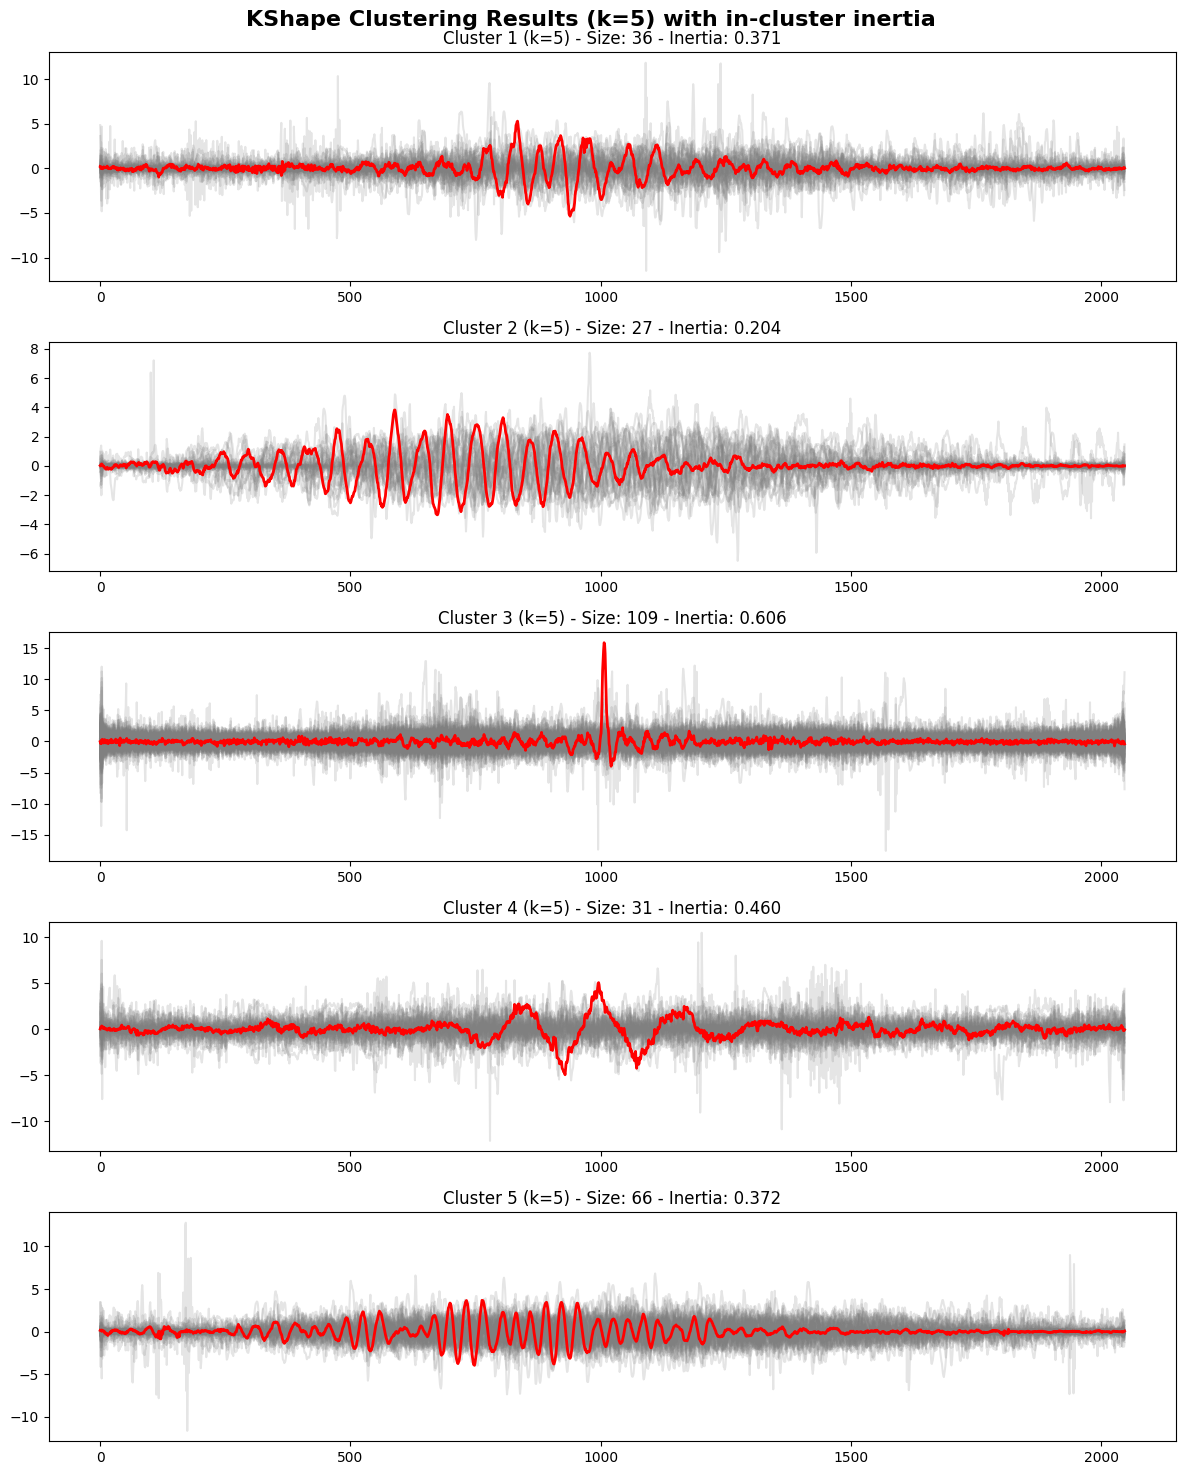

finished



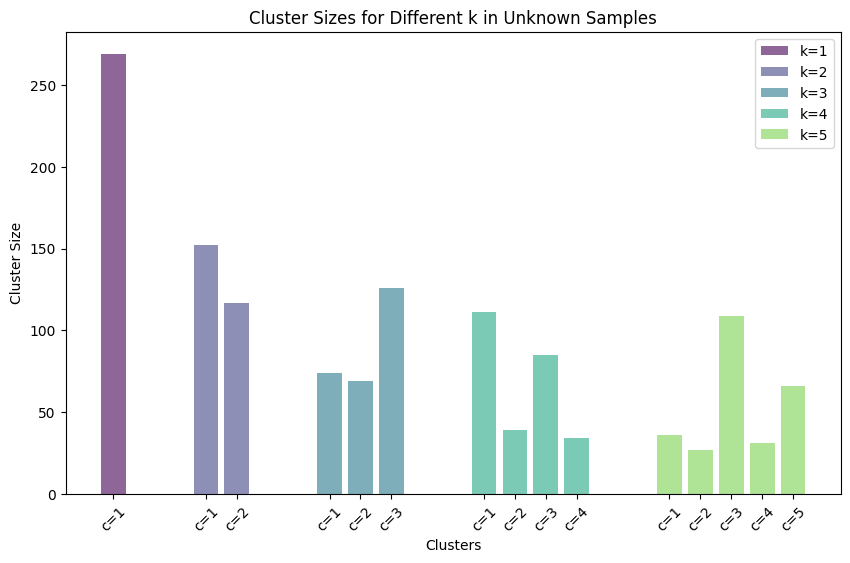

In [285]:
# plot inertia vs number of clusters for unknown samples
plt.figure(figsize=(8,6)), plt.gca()
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia for whole sample')
plt.plot(k_unknown_range, overall_inertia_ls, marker='o', color='tab:blue',label='Inertia')
plt.title('Inertia vs Number of Clusters k for Unknown Samples')
plt.show()

# plot each k's clusters & in-cluster inertia
for i, ks_unknown in enumerate(ks_unknown_ls):
    k = k_unknown_range[i]
    y_pred_unknown = y_pred_unknown_ls[i]
    print(f'----------Plotting clusters for unknown samples with k={k}----------')
    plot_clusters_with_in_cluster_inertia(ks_unknown, X_unknown, y_pred_unknown)
    print('finished\n')

# plot histogram to show clusters'size for all k in k_unknown_range, in a single figure, different k on x-axis
x_positions = []
heights = []
x_labels = []
current_x = 0
bar_width = 0.8
group_spacing = 2
fig,ax =plt.figure(figsize=(10,6)), plt.gca()
for i, cluster_sizes in enumerate(clusters_size_ls):
    n = len(cluster_sizes)
    xs = np.arange(current_x, current_x + n)
    ax.bar(xs, cluster_sizes, width=bar_width, alpha=0.6,label=f'k={k_unknown_range[i]}',color=plt.cm.viridis(i / len(clusters_size_ls)))
    x_positions.extend(xs)
    x_labels.extend([f'c={j+1}' for j in range(n)])
    current_x += (n+2)  # add space between different k groups

plt.xticks(x_positions, x_labels, rotation=45)
ax.set_xlabel('Clusters')
ax.set_ylabel('Cluster Size')
ax.set_title('Cluster Sizes for Different k in Unknown Samples')
plt.legend()
plt.show()

# # plot histogram to show clusters'size for all k in k_unknown_range, in a single figure, different k on x-axis
# plt.figure(figsize=(10,6))
# for i, cluster_sizes in enumerate(clusters_size_ls):
#     k = k_unknown_range[i]
#     plt.bar([f'k={k}, c={j+1}' for j in range(len(cluster_sizes))], cluster_sizes, alpha=0.6, label=f'k={k}')
# plt.xlabel('Clusters')
# plt.ylabel('Cluster Size')
# plt.title('Cluster Sizes for Different k in Unknown Samples')
# plt.legend()
# plt.show()

In [327]:
# compute sbd distance of unknown samples, use hdbscan to cluster unknown samples to see if new clusters exist in unknown samples
import hdbscan
from hdbscan import HDBSCAN

# compute sbd distance matrix for unknown samples
sbd_unknown = sbd_distance_matrix(X_unknown, X_unknown)
sbd_unknown_mod = sbd_unknown.copy()
sbd_unknown_mod[sbd_unknown_mod < 0.] = 0. # set negative distances to zero, set diagonal to zero
np.fill_diagonal(sbd_unknown_mod, 0.)
# print('Computed SBD distance matrix for unknown samples:')
# print(sbd_unknown_mod[np.arange(sbd_unknown_mod.shape[0]), np.arange(sbd_unknown_mod.shape[0])]) # print diagonal to verify
# use HDBSCAN to cluster unknown samples based on sbd distance matrix
hdbscan_unknown = HDBSCAN(min_cluster_size=20,min_samples=5, metric='precomputed',gen_min_span_tree=True)
label_unknown_hdbscan = hdbscan_unknown.fit_predict(sbd_unknown_mod)
print('sbd distance after hdbscan fit:')
print(sbd_unknown_mod[np.arange(sbd_unknown_mod.shape[0]), np.arange(sbd_unknown_mod.shape[0])]) # print diagonal to verify

# result of HDBSCAN clustering
n_clusters_hdbscan = len(set(label_unknown_hdbscan)) - (1 if -1 in label_unknown_hdbscan else 0)
n_noise_hdbscan = np.sum(label_unknown_hdbscan == -1)
print(f'HDBSCAN found {n_clusters_hdbscan} clusters and {n_noise_hdbscan} noise points in unknown samples')
# print(f'relative validity of HDBSCAN clustering: {hdbscan_unknown.relative_validity_}')
if hdbscan_unknown.minimum_spanning_tree_ is not None:
    print('HDBSCAN minimum spanning tree computed successfully.')
else:
    print('HDBSCAN minimum spanning tree not computed.')



sbd distance after hdbscan fit:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]
HDBSCAN found 2 clusters and 200 noise points in unknown samples
HDBSCAN minimum spanning tree not computed.


/home/kfang/gwsim/glitchstream/.gwsimenv/lib/python3.11/site-packages/hdbscan/hdbscan_.py:1555: UserWarning: No raw data is available; this may be due to using a precomputed metric matrix. No minimum spanning tree will be provided without raw data.
  warn(


In [320]:
np.unique_counts(label_unknown_hdbscan)

UniqueCountsResult(values=array([-1,  0,  1]), counts=array([194,  46,  29]))

/home/kfang/gwsim/glitchstream/.gwsimenv/lib/python3.11/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/kfang/gwsim/glitchstream/.gwsimenv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


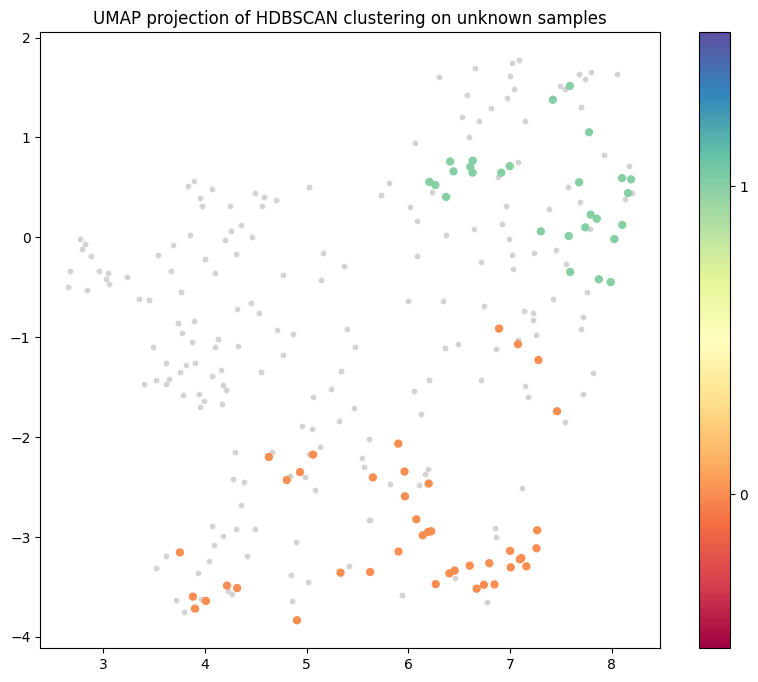

In [393]:
# UMAP visualization of HDBSCAN clustering results
import umap
reducer = umap.UMAP(metric='precomputed', random_state=42)
embedding = reducer.fit_transform(sbd_unknown_mod)
plt.figure(figsize=(10,8))
noise_mask = label_unknown_hdbscan == -1
plt.scatter(embedding[noise_mask,0], embedding[noise_mask,1], c='lightgray', s=10)
cluster_mask = ~noise_mask
scatter = plt.scatter(embedding[cluster_mask,0], embedding[cluster_mask,1], c=label_unknown_hdbscan[cluster_mask],cmap='Spectral', s=25, vmin=-0.5, vmax=n_clusters_hdbscan - 0.5)
plt.colorbar(scatter).set_ticks(np.arange(n_clusters_hdbscan))
plt.title('UMAP projection of HDBSCAN clustering on unknown samples')
plt.show()

In [324]:
# silhouette score for HDBSCAN clustering with sbd distance
from tslearn.clustering import silhouette_score

s_score = silhouette_score(sbd_unknown_mod, label_unknown_hdbscan, metric='precomputed', random_state=42) # quality of our HDBSCAN clustering
print(f'Silhouette Score for HDBSCAN clustering on unknown samples: {s_score:.4f}')

Silhouette Score for HDBSCAN clustering on unknown samples: -0.0006


----------Plotting clusters for HDBSCAN cluster 0----------


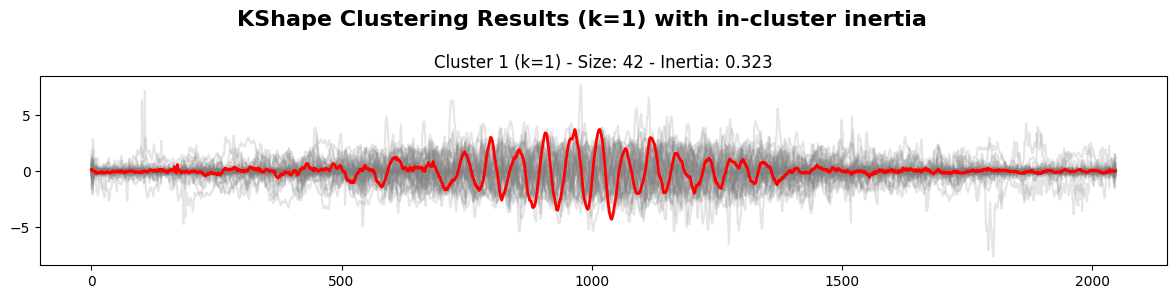

----------Plotting clusters for HDBSCAN cluster 1----------


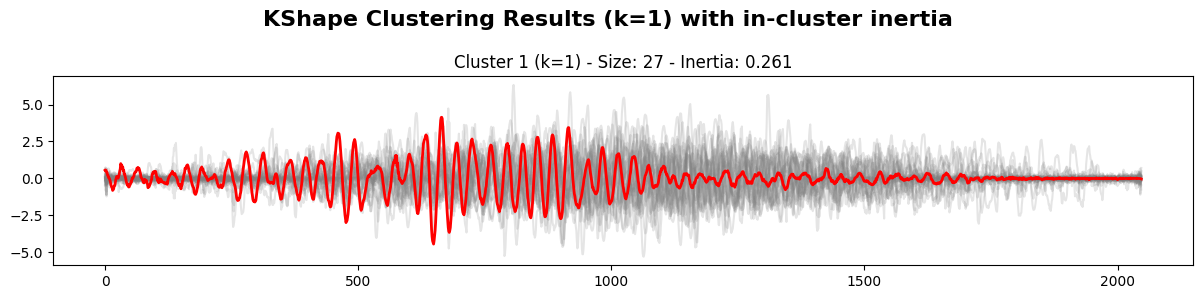

In [349]:
# pick meaningful clusters from HDBSCAN and compute their in-cluster inertia with kShape
X_cls_unknown_ls = []
y_cls_unknown_ls = []
centroid_unknown_ls = []
label_cls_unknown = label_unknown_hdbscan[label_unknown_hdbscan != -1] # exclude noise points
for i in np.unique(label_cls_unknown):
    X_cls_unknown_ls.append(X_unknown[label_unknown_hdbscan == i])
    y_cls_unknown_ls.append(label_unknown_hdbscan[label_unknown_hdbscan == i])
for i in range(len(X_cls_unknown_ls)):
    ks_unknown_cls_hdbscan = KShape(n_clusters=1, random_state=42, init='random', n_init=10)
    y_pred_unknown_cls_hdbscan = ks_unknown_cls_hdbscan.fit_predict(X_cls_unknown_ls[i])
    centroid_unknown_ls.append(ks_unknown_cls_hdbscan.cluster_centers_[0].reshape(1,2048,1))
    print(f'----------Plotting clusters for HDBSCAN cluster {i}----------')
    plot_clusters_with_in_cluster_inertia(ks_unknown_cls_hdbscan, X_cls_unknown_ls[i], y_pred_unknown_cls_hdbscan)

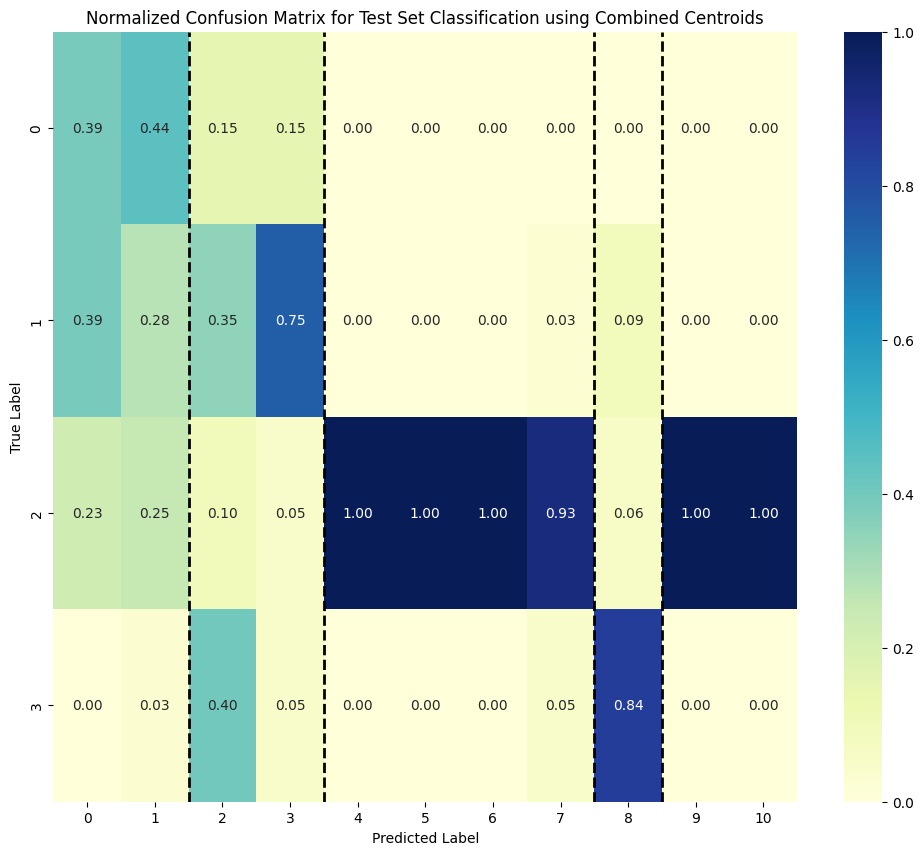

In [360]:
import seaborn as sns

X_test_ts = to_time_series_dataset(ghat_test)
X_test_ts_resampled = TimeSeriesResampler(sz=sz_resample).fit_transform(X_test_ts)
X_test_ts_scaled = TimeSeriesScalerMeanVariance().fit_transform(X_test_ts_resampled)

# construct classifier and confusion matrix, combine all centroids from known classes and unknown classes for test set evaluation
total_centroids = np.concatenate([all_centroids, np.concatenate(centroid_unknown_ls, axis=0)], axis=0)
distance_matrix_test = sbd_distance_matrix(X_test_ts_scaled, total_centroids) # shape (n_samples, n_total_centroids)
y_pred_test = np.argmin(distance_matrix_test, axis=1)

y_true_test_ls = []
for i in range(X_test_ts_scaled.shape[0]):
    for j in range(len(ghat_labels_uq)):
        if label_test[i] == ghat_labels_uq[j]:
            y_true_test_ls.append(j)
            break
y_true_test = np.array(y_true_test_ls)

conf_matrix = pd.crosstab(y_true_test, y_pred_test, rownames=['True Label'], colnames=['Predicted Label'])
# normalize confusion matrix along predicted labels
conf_matrix_normalized = conf_matrix.div(conf_matrix.sum(axis=0))

fig,ax = plt.subplots(figsize=(12,10))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='YlGnBu')
cls_divide = [2,4,8,9]
for x_pos in cls_divide:
    ax.axvline(x=x_pos,color='black',linewidth=2,linestyle='dashed')
ax.plot()
plt.title('Normalized Confusion Matrix for Test Set Classification using Combined Centroids')
plt.show() 

In [ ]:
# compute silhouette score to evaluate clustering performance !!!VERY SLOW 15 minutes!!!

# first define KShape distance metric SBD
from tslearn.metrics import cdist_normalized_cc

def sbd_distance_matrix(X,Y):
    X_norms = np.linalg.norm(X,axis=(1,2))
    Y_norms = np.linalg.norm(Y,axis=(1,2))
    ncc_matrix = cdist_normalized_cc(X,Y,norms1=X_norms,norms2=Y_norms,self_similarity=False)
    return 1. - ncc_matrix

# compute distance matrix for training set
dist = sbd_distance_matrix(X_train_ts_scaled,X_train_ts_scaled)
print(dist.shape)

(1600, 1600)


In [ ]:
# compute silhouette score
from tslearn.clustering import silhouette_score

dist_modified = dist.copy()
for i in range(dist.shape[0]):
    dist_modified[i,i] = 0.0 ## set diagonal to zero; which should be zero for diagonal elements(distance to itself)

dist_modified[77,447] = 0.
dist_modified[447,77] = 0. # two distinct negative distances (1e-6) set to zero

s_score_initialized = silhouette_score(dist_modified, y_pred_ks, metric="precomputed")
print(f"Silhouette score for KShape with initialized centroids: {s_score_initialized}")

Silhouette score for KShape with initialized centroids: 0.2599402796609082


In [171]:
s_score_random = silhouette_score(dist_modified, y_pred_ks_random, metric="precomputed")
print(f"Silhouette score for KShape with random initialization: {s_score_random}")

Silhouette score for KShape with random initialization: 0.24659707319872368


In [ ]:
# test other measurements in distance matrix computation !!! DO NOT TRY extremely slow O(L^2)!!!
s_score_softdtw = silhouette_score(X_train_ts_scaled,y_pred_ks,metric="softdtw")
print(s_score_softdtw)

(1600,)
(1600,)


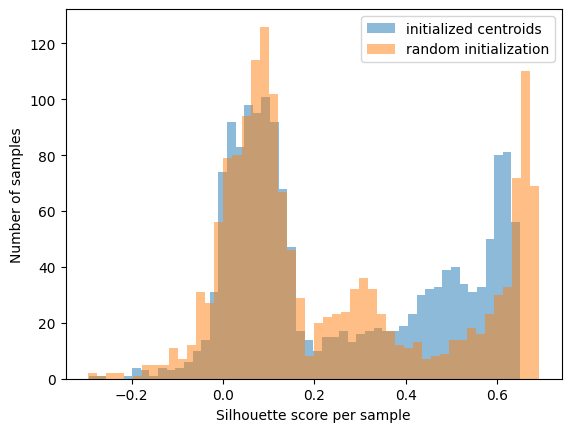

In [177]:
# silhouette scores for each sample
from sklearn.metrics import silhouette_samples

s_samples_initialized = silhouette_samples(dist_modified, y_pred_ks, metric="precomputed")
s_samples_random = silhouette_samples(dist_modified, y_pred_ks_random, metric="precomputed")
print(s_samples_initialized.shape)
print(s_samples_random.shape)
plt.hist(s_samples_initialized,bins=50,alpha=0.5,label='initialized centroids')
plt.hist(s_samples_random,bins=50,alpha=0.5,label='random initialization')
plt.xlabel("Silhouette score per sample")
plt.ylabel("Number of samples")
plt.legend()
plt.show()

In [59]:
from tslearn.metrics import cdist_normalized_cc

ncc = cdist_normalized_cc(np.array(X_train_ts_scaled[1]).reshape(1,2048,1),np.array(ks.cluster_centers_[1]).reshape(1,2048,1),norms1=ks.norms_,norms2=ks.norms_centroids_,self_similarity=False)
print(ncc)

ncc1 = cdist_normalized_cc(X_train_ts_scaled,ks.cluster_centers_,norms1=ks.norms_,norms2=ks.norms_centroids_,self_similarity=False)
print(ncc1[:5])
print(np.argmax(ncc1,axis=1)[:10])
print(np.argmin(ks._cross_dists(X_train_ts_scaled),axis=1)[:10])
print(ks.labels_[:10])
cdist_normalized_cc(np.array(X_train_ts_scaled[1]).reshape(1,2048,1),np.array(X_train_ts_scaled[1]).reshape(1,2048,1),norms1=ks.norms_,norms2=ks.norms_centroids_,self_similarity=False)


[[0.44473317]]
[[0.13710895 0.14947254 0.31762479 0.22832499]
 [0.21311506 0.44473317 0.30378181 0.88902776]
 [0.17589177 0.08571919 0.20350417 0.13844847]
 [0.25101003 0.35458727 0.35956478 0.96014054]
 [0.25749444 0.83065209 0.05538798 0.15508795]]
[2 3 2 3 1 3 3 2 1 3]
[2 3 2 3 1 3 3 2 1 3]
[2 3 2 3 1 3 3 2 1 3]


array([[1.]])

In [61]:
print(ks._cross_dists(X_train_ts_scaled)[:10])

[[0.86289105 0.85052746 0.68237521 0.77167501]
 [0.78688494 0.55526683 0.69621819 0.11097224]
 [0.82410823 0.91428081 0.79649583 0.86155153]
 [0.74898997 0.64541273 0.64043522 0.03985946]
 [0.74250556 0.16934791 0.94461202 0.84491205]
 [0.7211136  0.61230145 0.69546743 0.01941978]
 [0.58141438 0.72195978 0.49605289 0.39698965]
 [0.81837298 0.88811472 0.63834287 0.71627488]
 [0.3656261  0.35797451 0.91489926 0.69279665]
 [0.84981881 0.85848283 0.71617235 0.56984624]]


In [84]:
try_distmatrix = sbd_distance_matrix(X_train_ts_scaled,X_train_ts_scaled)
print(try_distmatrix.shape)

(1600, 1600)


In [339]:
type(np.argmin(try_distmatrix,axis=1))

numpy.ndarray

In [286]:
try_distmatrix[123,123]

np.float64(0.0)

In [209]:
try_distmatrix[0].min(axis=0)

np.float64(2.220446049250313e-16)

In [205]:
trymask = try_distmatrix.min(axis=1) > 0.1
print(sum(trymask))

0


In [88]:
(try_distmatrix**2)

array([[4.93038066e-32, 5.73025092e-01, 5.91935624e-01, ...,
        5.66873740e-01, 7.00316869e-01, 3.83066820e-01],
       [5.73025092e-01, 0.00000000e+00, 7.21880670e-01, ...,
        6.72326247e-01, 2.55317971e-01, 1.98757569e-01],
       [5.91935624e-01, 7.21880670e-01, 4.93038066e-32, ...,
        6.61216279e-01, 6.72686798e-01, 6.63976070e-01],
       ...,
       [5.66873740e-01, 6.72326247e-01, 6.61216279e-01, ...,
        4.93038066e-32, 7.72641223e-01, 6.35070004e-01],
       [7.00316869e-01, 2.55317971e-01, 6.72686798e-01, ...,
        7.72641223e-01, 4.93038066e-32, 2.65095971e-01],
       [3.83066820e-01, 1.98757569e-01, 6.63976070e-01, ...,
        6.35070004e-01, 2.65095971e-01, 4.93038066e-32]],
      shape=(1600, 1600))

In [67]:
def sbd_distance_matrix(X,Y):
    X_norms = np.linalg.norm(X,axis=(1,2))
    Y_norms = np.linalg.norm(Y,axis=(1,2))
    ncc_matrix = cdist_normalized_cc(X,Y,norms1=X_norms,norms2=Y_norms,self_similarity=False)
    return 1. - ncc_matrix
1- sbd_distance_matrix(np.array(X_train_ts_scaled[1]).reshape(1,2048,1),np.array(ks.cluster_centers_[1]).reshape(1,2048,1))

array([[0.44473317]])

In [29]:
cross_distance_matrix_from_centroids = ks._cross_dists(X_train_ts_scaled)
n_ts = cross_distance_matrix_from_centroids.shape[0]
computed_inertia = np.sum(cross_distance_matrix_from_centroids[np.arange(n_ts), ks.labels_]**2)/n_ts
print(computed_inertia,ks.inertia_)

0.2255067373506284 0.2255067373506284


In [58]:
try_distance_matrix_from_centroids = ks._cross_dists(np.array([X_train_ts_scaled[114]]))
try_distance_matrix_from_centroids.shape

(1, 4)

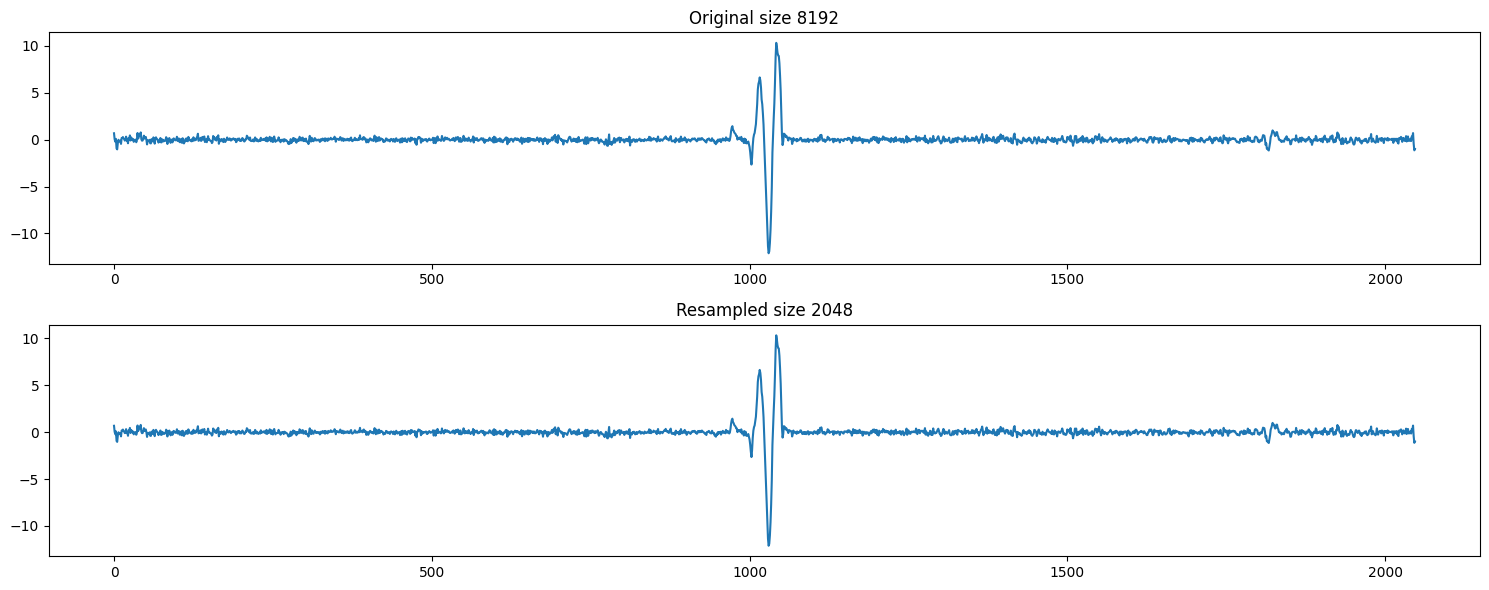

2048 2048


In [391]:
# Example of resampling time series to a different length for quicker KShape clustering
from tslearn.preprocessing import TimeSeriesResampler

target_sz = 2048
X_resampled = TimeSeriesResampler(sz=target_sz).fit_transform(X_train_ts_scaled)

plt.figure(figsize=(15,6))

plt.subplot(2,1,1)
plt.plot(X_train_ts_scaled[191].ravel())
plt.title("Original size 8192")

plt.subplot(2,1,2)
plt.plot(X_resampled[191].ravel())
plt.title(f"Resampled size {target_sz}")

plt.tight_layout()
plt.show()

print(X_train_ts_scaled.shape[1],X_resampled.shape[1])

In [53]:
X_types = []
for i in range(len(ghat_labels_uq)):
    X_types.append(X_train_ts_scaled[label_train == ghat_labels_uq[i]])
sumx = 0
X_init = []
for i in range(len(X_types)):
    sumx += X_types[i].shape[0]
    print(X_types[i].shape[0])
    X_init.append(X_types[i][np.random.randint(X_types[i].shape[0])])
print(sumx)
print(np.array(X_init).shape)


137
228
751
484
1600
(4, 2048, 1)


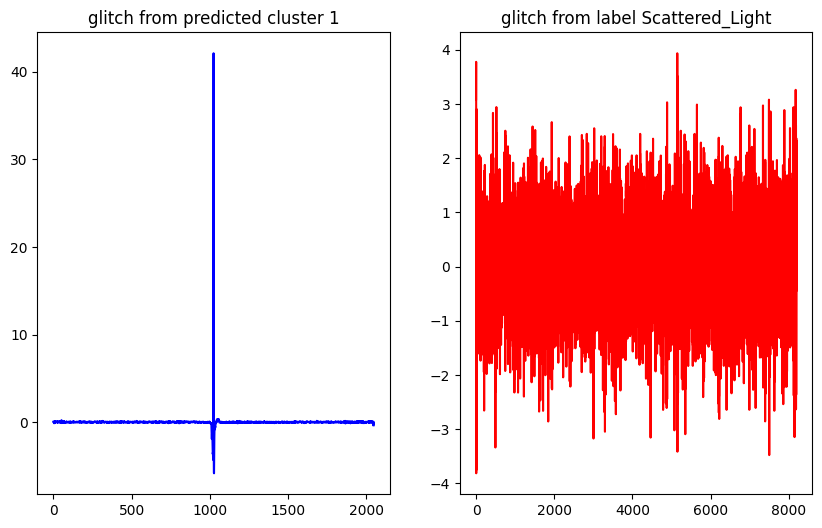

In [14]:
rand_type1_glitch_pred = X_train_ts_scaled[y_pred_ks == 0][np.random.randint(X_train_ts_scaled[y_pred_ks == 0].shape[0])].ravel()
rand_type1_glitch_orig = X_train_ts[label_train == ghat_labels_uq[2]][np.random.randint(X_train_ts[label_train == ghat_labels_uq[0]].shape[0])].ravel()
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(rand_type1_glitch_pred,"b-")
plt.title(f"glitch from predicted cluster 1")
plt.subplot(1,2,2)
plt.plot(rand_type1_glitch_orig,"r-")
plt.title(f"glitch from label {ghat_labels_uq[2]}")
plt.show()

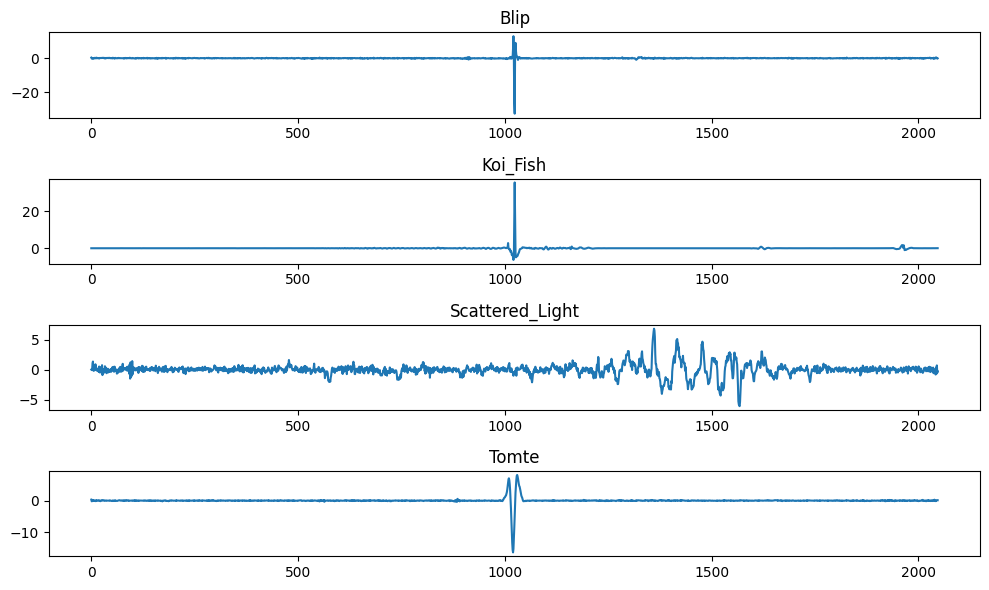

In [ ]:
# Plot random examples from each known glitch class after normalization and scaling
plt.figure(figsize=(10,6))
for i in range(len(ghat_labels_uq)):
    picked = X_train_ts_scaled[label_train == ghat_labels_uq[i]]
    plt.subplot(len(ghat_labels_uq),1,i+1)
    plt.plot(picked[np.random.randint(len(picked))].ravel())
    plt.title(f"{ghat_labels_uq[i]}")

plt.tight_layout()
plt.show()